<a href="https://colab.research.google.com/github/NiyonshutiDavid/uruti-platform/blob/main/Notebooks/uruti-MLP_models/ModelCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# URUTI Platform: Investor Intelligence Engine
**Scope:** Investor intelligence only (MLOps-ready tabular pipeline)

This notebook uses **three local CSV sources** already available in `Notebooks/Data` to build a unified investor-success prediction dataset.
It performs:

1. Data loading and harmonization across 3 datasets
2. Missing-data handling and preprocessing
3. Exploratory analysis and visualization
4. Training and comparison of six models
5. Metrics reporting (accuracy, precision, recall, F1, ROC-AUC, confusion matrix)
6. Saving the best model artifact into the root `Models` folder

## 1) Setup & Paths

In [13]:
import os
import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
 )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd().resolve()
print(f"Kernel CWD: {CWD}")

ENV_DATA_DIR = os.getenv("URUTI_DATA_DIR")
DATA_DIR = None

if ENV_DATA_DIR:
    override_path = Path(ENV_DATA_DIR).expanduser().resolve()
    if override_path.exists():
        DATA_DIR = override_path

if DATA_DIR is None:
    candidate_roots = [CWD, *CWD.parents]
    data_candidates = []
    for base in candidate_roots:
        data_candidates.append(base / "Data")
        data_candidates.append(base / "Notebooks" / "Data")

    # Local macOS synced Drive and workspace paths
    data_candidates.extend([
        Path("/Users/davidniyonshutii/Documents/MissionCapstone/uruti-platform/Notebooks/Data"),
        Path("/Users/davidniyonshutii/Library/CloudStorage/GoogleDrive-d.niyonshut@alustudent.com/My Drive/ALU-Course_Documents/Mission capstone/uruti-platform/Notebooks/Data"),
        Path("/Users/davidniyonshutii/Library/CloudStorage/GoogleDrive-d.niyonshut@alustudent.com/My Drive/ALU-Course_Documents/Mission capstone/Notebooks/Data"),
    ])

    # Colab mounted Drive paths
    data_candidates.extend([
        Path("/content/drive/MyDrive/ALU-Course_Documents/Mission capstone/uruti-platform/Notebooks/Data"),
        Path("/content/drive/MyDrive/ALU-Course_Documents/Mission capstone/Notebooks/Data"),
        Path("/content/drive/MyDrive/Mission capstone/uruti-platform/Notebooks/Data"),
        Path("/content/drive/MyDrive/Mission capstone/Notebooks/Data"),
    ])

    DATA_DIR = next((p for p in data_candidates if p.exists()), None)

if DATA_DIR is None:
    # Last-resort recursive search in likely mounted roots
    search_roots = [Path("/content/drive/MyDrive"), Path("/Users/davidniyonshutii")]
    for root in search_roots:
        if root.exists():
            try:
                match = next(root.rglob("50_Startups.csv"), None)
                if match is not None:
                    DATA_DIR = match.parent
                    break
            except Exception:
                pass

if DATA_DIR is None:
    raise FileNotFoundError(
        "Could not locate Data directory. Set URUTI_DATA_DIR to folder containing: "
        "50_Startups.csv, investments_VC.csv, startup data.csv"
    )

NOTEBOOK_DIR = DATA_DIR.parent / "uruti-MLP_models" if (DATA_DIR.parent / "uruti-MLP_models").exists() else CWD

ROOT_DIR = next((p for p in [DATA_DIR.parent.parent, *DATA_DIR.parent.parent.parents] if (p / "Models").exists()), DATA_DIR.parent.parent)
MODELS_DIR = ROOT_DIR / "Models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    HAS_TF = True
except Exception:
    HAS_TF = False

CLASS_NAMES = ["not_ready", "mentorship_needed", "investment_ready"]
CLASS_TO_ID = {name: idx for idx, name in enumerate(CLASS_NAMES)}
ID_TO_CLASS = {v: k for k, v in CLASS_TO_ID.items()}

print(f"Notebook dir (resolved): {NOTEBOOK_DIR}")
print(f"Data dir: {DATA_DIR}")
print(f"Models dir: {MODELS_DIR}")
print(f"XGBoost available: {HAS_XGBOOST}")
print(f"TensorFlow available: {HAS_TF}")
print(f"Class mapping: {CLASS_TO_ID}")

Kernel CWD: /content
Notebook dir (resolved): /content
Data dir: /content/drive/MyDrive/ALU-Course_Documents/Mission capstone/Data
Models dir: /content/drive/MyDrive/ALU-Course_Documents/Models
XGBoost available: True
TensorFlow available: True
Class mapping: {'not_ready': 0, 'mentorship_needed': 1, 'investment_ready': 2}


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) Load the Three Local Data Sources

We load three CSV files with different schemas and data quality issues. Each source contains startup information but with varying column structures, encoding formats, and business domains. This step reads all three datasets and applies basic column name standardization.

In [15]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace(".", "_", regex=False)
    )
    return df

def parse_money(series: pd.Series) -> pd.Series:
    cleaned = (
        series.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
        .str.replace("-", "", regex=False)
        .str.replace("$", "", regex=False)
    )
    return pd.to_numeric(cleaned, errors="coerce")

def normalize_text(series: pd.Series, upper=False) -> pd.Series:
    out = series.astype(str).str.strip()
    out = out.replace({"": np.nan, "nan": np.nan, "none": np.nan, "null": np.nan, "-": np.nan})
    return out.str.upper() if upper else out.str.lower()

def map_status_to_class(status_value: str) -> str:
    s = str(status_value).strip().lower()
    if s in {"acquired", "ipo", "public"}:
        return "investment_ready"
    if s in {"operating"}:
        return "mentorship_needed"
    if s in {"closed"}:
        return "not_ready"
    return "mentorship_needed"

def read_csv_robust(path: Path, **kwargs) -> pd.DataFrame:
    last_err = None
    for enc in ["utf-8", "latin-1", "cp1252"]:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except UnicodeDecodeError as err:
            last_err = err
    raise last_err

df_50 = read_csv_robust(DATA_DIR / "50_Startups.csv")
df_vc = read_csv_robust(DATA_DIR / "investments_VC.csv", low_memory=False)
df_startup = read_csv_robust(DATA_DIR / "startup data.csv", low_memory=False)

df_50 = clean_column_names(df_50)
df_vc = clean_column_names(df_vc)
df_startup = clean_column_names(df_startup)

print("Loaded datasets:")
print(f"- 50_Startups: {df_50.shape}")
print(f"- investments_VC: {df_vc.shape}")
print(f"- startup data: {df_startup.shape}")

display(df_50.head(2))
display(df_vc.head(2))
display(df_startup.head(2))

# Show data quality per dataset BEFORE combining
print("\n" + "="*80)
print("DATA QUALITY ANALYSIS PER DATASET (BEFORE UNIFICATION)")
print("="*80)

for name, df in [("50_Startups", df_50), ("investments_VC", df_vc), ("startup_data", df_startup)]:
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Missing values (% per column):")
    missing = (df.isna().mean() * 100).sort_values(ascending=False)
    print(missing[missing > 0].to_string())
    print(f"\nData types:")
    print(df.dtypes.value_counts().to_string())

Loaded datasets:
- 50_Startups: (50, 5)
- investments_VC: (54294, 39)
- startup data: (923, 49)


,r&d_spend,administration,marketing_spend,state,profit
0,165349.2,136897.80,471784.10,New York,192261.83
1,162597.7,151377.59,443898.53,California,191792.06


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_a,round_b,round_c,round_d,round_e,round_f,round_g,round_h
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,unnamed:_0,state_code,latitude,longitude,zip_code,id,city,unnamed:_6,name,labels,...,object_id,has_vc,has_angel,has_rounda,has_roundb,has_roundc,has_roundd,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.00,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.75,1,acquired



DATA QUALITY ANALYSIS PER DATASET (BEFORE UNIFICATION)

--- 50_Startups ---
Shape: (50, 5)
Missing values (% per column):
Series([], )

Data types:
float64    4
object     1

--- investments_VC ---
Shape: (54294, 39)
Missing values (% per column):
state_code              44.448742
founded_quarter         29.122923
founded_month           29.122923
founded_year            29.122923
founded_at              28.990312
city                    20.208494
region                  18.655837
country_code            18.655837
market                  16.252256
category_list           16.239363
homepage_url            15.296350
status                  11.364055
name                     8.945740
funding_total_usd        8.943898
permalink                8.943898
funding_rounds           8.943898
first_funding_at         8.943898
last_funding_at          8.943898
seed                     8.943898
venture                  8.943898
equity_crowdfunding      8.943898
undisclosed              8.943898
con

## 3. Harmonize Schemas + Build Unified Training Table

- Top 33% profit → investment_ready

This section transforms each dataset into a common schema with 12 shared columns. We apply source-specific transformations: (1) **50_Startups** derives readiness classes from profit tertiles, (2) **startup_data** and (3) **investments_VC** map status values to readiness classes. Finally, all three datasets are vertically concatenated into a single unified dataframe.- Middle 33% profit → mentorship_needed

- Bottom 33% profit → not_ready

### Class Labeling Requirements:For the 50_Startups dataset (no status column), we use profit tertiles:

- **investment_ready**: Startups with status 'acquired', 'ipo', or 'public' (successful exits)

- **mentorship_needed**: Startups with status 'operating' (ongoing operations, default category)- **not_ready**: Startups with status 'closed' or lowest profit tertile (failed/struggling)

In [16]:
TARGET_COL = "readiness_class_id"
TARGET_TEXT_COL = "readiness_class"

# ----- A) Source 1: 50_Startups (derive 3-class readiness from profit tertiles) -----
startup_50 = df_50.copy()
startup_50["rd_spend"] = pd.to_numeric(startup_50.get("r&d_spend"), errors="coerce")
startup_50["administration_spend"] = pd.to_numeric(startup_50.get("administration"), errors="coerce")
startup_50["marketing_spend"] = pd.to_numeric(startup_50.get("marketing_spend"), errors="coerce")
startup_50["profit"] = pd.to_numeric(startup_50.get("profit"), errors="coerce")
startup_50["funding_total_usd"] = startup_50[["rd_spend", "administration_spend", "marketing_spend"]].sum(axis=1, min_count=1)
startup_50["funding_rounds"] = 1
startup_50["founded_year"] = np.nan
startup_50["state_code"] = normalize_text(startup_50.get("state", pd.Series(index=startup_50.index)), upper=True)
startup_50["category_code"] = "unknown"
startup_50["status"] = np.nan

q1 = startup_50["profit"].quantile(0.33)
q2 = startup_50["profit"].quantile(0.66)
startup_50[TARGET_TEXT_COL] = np.select(
    [startup_50["profit"] <= q1, startup_50["profit"] <= q2],
    ["not_ready", "mentorship_needed"],
    default="investment_ready",
)
startup_50["source"] = "50_startups"

# ----- B) Source 2: startup data -----
startup_main = df_startup.copy()
startup_main["funding_total_usd"] = pd.to_numeric(startup_main.get("funding_total_usd"), errors="coerce")
startup_main["funding_rounds"] = pd.to_numeric(startup_main.get("funding_rounds"), errors="coerce")
startup_main["founded_year"] = pd.to_datetime(startup_main.get("founded_at"), errors="coerce").dt.year
startup_main["state_code"] = normalize_text(startup_main.get("state_code", pd.Series(index=startup_main.index)), upper=True)
startup_main["category_code"] = normalize_text(startup_main.get("category_code", pd.Series(index=startup_main.index)), upper=False)
startup_main["rd_spend"] = np.nan
startup_main["administration_spend"] = np.nan
startup_main["marketing_spend"] = np.nan
startup_main["profit"] = np.nan
startup_main["status"] = normalize_text(startup_main.get("status", pd.Series(index=startup_main.index)), upper=False)
startup_main[TARGET_TEXT_COL] = startup_main["status"].map(map_status_to_class)
startup_main["source"] = "startup_data"

# ----- C) Source 3: investments_VC -----
vc = df_vc.copy()
vc["funding_total_usd"] = parse_money(vc.get("funding_total_usd", pd.Series(index=vc.index)))
vc["funding_rounds"] = pd.to_numeric(vc.get("funding_rounds"), errors="coerce")
vc["founded_year"] = pd.to_numeric(vc.get("founded_year"), errors="coerce")
vc["state_code"] = normalize_text(vc.get("state_code", pd.Series(index=vc.index)), upper=True)
vc["category_code"] = normalize_text(vc.get("market", pd.Series(index=vc.index)), upper=False)
vc["rd_spend"] = np.nan
vc["administration_spend"] = np.nan
vc["marketing_spend"] = np.nan
vc["profit"] = np.nan
vc["status"] = normalize_text(vc.get("status", pd.Series(index=vc.index)), upper=False)
vc[TARGET_TEXT_COL] = vc["status"].map(map_status_to_class)
vc["source"] = "investments_vc"

COMMON_COLUMNS = [
    "funding_total_usd",
    "funding_rounds",
    "founded_year",
    "rd_spend",
    "administration_spend",
    "marketing_spend",
    "profit",
    "state_code",
    "category_code",
    "source",
    "status",
    TARGET_TEXT_COL,
]

unified_df = pd.concat(
    [
        startup_50.reindex(columns=COMMON_COLUMNS),
        startup_main.reindex(columns=COMMON_COLUMNS),
        vc.reindex(columns=COMMON_COLUMNS),
    ],
    ignore_index=True,
    axis=0,
)

unified_df[TARGET_TEXT_COL] = unified_df[TARGET_TEXT_COL].fillna("mentorship_needed")
unified_df[TARGET_TEXT_COL] = unified_df[TARGET_TEXT_COL].where(
    unified_df[TARGET_TEXT_COL].isin(CLASS_NAMES), "mentorship_needed"
)
unified_df[TARGET_COL] = unified_df[TARGET_TEXT_COL].map(CLASS_TO_ID).astype(int)

# Basic inconsistency fixes
unified_df["state_code"] = normalize_text(unified_df["state_code"], upper=True).fillna("UNK")
unified_df["category_code"] = normalize_text(unified_df["category_code"], upper=False).fillna("unknown")
unified_df["source"] = normalize_text(unified_df["source"], upper=False).fillna("unknown")

print(f"Unified dataset shape: {unified_df.shape}")
print("Class distribution:")
print(unified_df[TARGET_TEXT_COL].value_counts())
print("Source distribution:")
print(unified_df["source"].value_counts())
display(unified_df.head())

# Show preprocessing status AFTER unification
class_dist = unified_df[TARGET_TEXT_COL].value_counts(normalize=True) * 100
unified_missing = (unified_df.isna().mean() * 100).sort_values(ascending=False)

print("\n" + "=" * 80)
print("DATA QUALITY AFTER UNIFICATION")
print("=" * 80)

print("\nClass balance:")
for cls, pct in class_dist.items():
    print(f"  {cls}: {pct:.2f}% ({unified_df[TARGET_TEXT_COL].value_counts()[cls]:,} records)")

print(f"\nTotal records: {len(unified_df):,}")
print(f"Total features: {unified_df.shape[1]}")

print("\nMissing values (% per column):")
print(unified_missing[unified_missing > 0].to_string())

Unified dataset shape: (55267, 13)
Class distribution:
readiness_class
mentorship_needed    48015
investment_ready      4306
not_ready             2946
Name: count, dtype: int64
Source distribution:
source
investments_vc    54294
startup_data        923
50_startups          50
Name: count, dtype: int64


,funding_total_usd,funding_rounds,founded_year,rd_spend,administration_spend,marketing_spend,profit,state_code,category_code,source,status,readiness_class,readiness_class_id
0,774031.10,1.0,NaN,165349.20,136897.80,471784.10,192261.83,NEW YORK,unknown,50_startups,NaN,investment_ready,2
1,757873.82,1.0,NaN,162597.70,151377.59,443898.53,191792.06,CALIFORNIA,unknown,50_startups,NaN,investment_ready,2
2,662521.60,1.0,NaN,153441.51,101145.55,407934.54,191050.39,FLORIDA,unknown,50_startups,NaN,investment_ready,2
3,646243.88,1.0,NaN,144372.41,118671.85,383199.62,182901.99,NEW YORK,unknown,50_startups,NaN,investment_ready,2
4,599667.53,1.0,NaN,142107.34,91391.77,366168.42,166187.94,FLORIDA,unknown,50_startups,NaN,investment_ready,2



DATA QUALITY AFTER UNIFICATION

Class balance:
  mentorship_needed: 86.88% (48,015 records)
  investment_ready: 7.79% (4,306 records)
  not_ready: 5.33% (2,946 records)

Total records: 55,267
Total features: 13

Missing values (% per column):
administration_spend    99.909530
rd_spend                99.909530
marketing_spend         99.909530
profit                  99.909530
founded_year            28.700671
funding_total_usd       24.222411
status                  11.254456
funding_rounds           8.786437


## 4) Data Quality, Missing Values, and EDA

We perform exploratory data analysis on the unified dataset to understand distributions, correlations, and data quality issues. This includes statistical summaries, missing value analysis, and visualizations of class distributions, funding patterns, and feature correlations.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
funding_total_usd,41880.0,NaN,NaN,NaN,16103544.320049,169072292.561041,1.0,360000.0,2000000.0,10000000.0,30079503000.0
funding_rounds,50411.0,NaN,NaN,NaN,1.70677,1.298203,1.0,1.0,1.0,2.0,18.0
founded_year,39405.0,NaN,NaN,NaN,2007.315493,7.514618,1902.0,2005.0,2009.0,2012.0,2014.0
rd_spend,50.0,NaN,NaN,NaN,73721.6156,45902.256482,0.0,39936.37,73051.08,101602.8,165349.2
administration_spend,50.0,NaN,NaN,NaN,121344.6396,28017.802755,51283.14,103730.875,122699.795,144842.18,182645.56
marketing_spend,50.0,NaN,NaN,NaN,211025.0978,122290.310726,0.0,129300.1325,212716.24,299469.085,471784.1
profit,50.0,NaN,NaN,NaN,112012.6392,40306.180338,14681.4,90138.9025,107978.19,139765.9775,192261.83
state_code,55267,65,UNK,24133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_code,55267,768,unknown,8874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,55267,3,investments_vc,54294,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,missing_pct
administration_spend,99.909530
rd_spend,99.909530
marketing_spend,99.909530
profit,99.909530
founded_year,28.700671
funding_total_usd,24.222411
status,11.254456
funding_rounds,8.786437
state_code,0.000000
category_code,0.000000


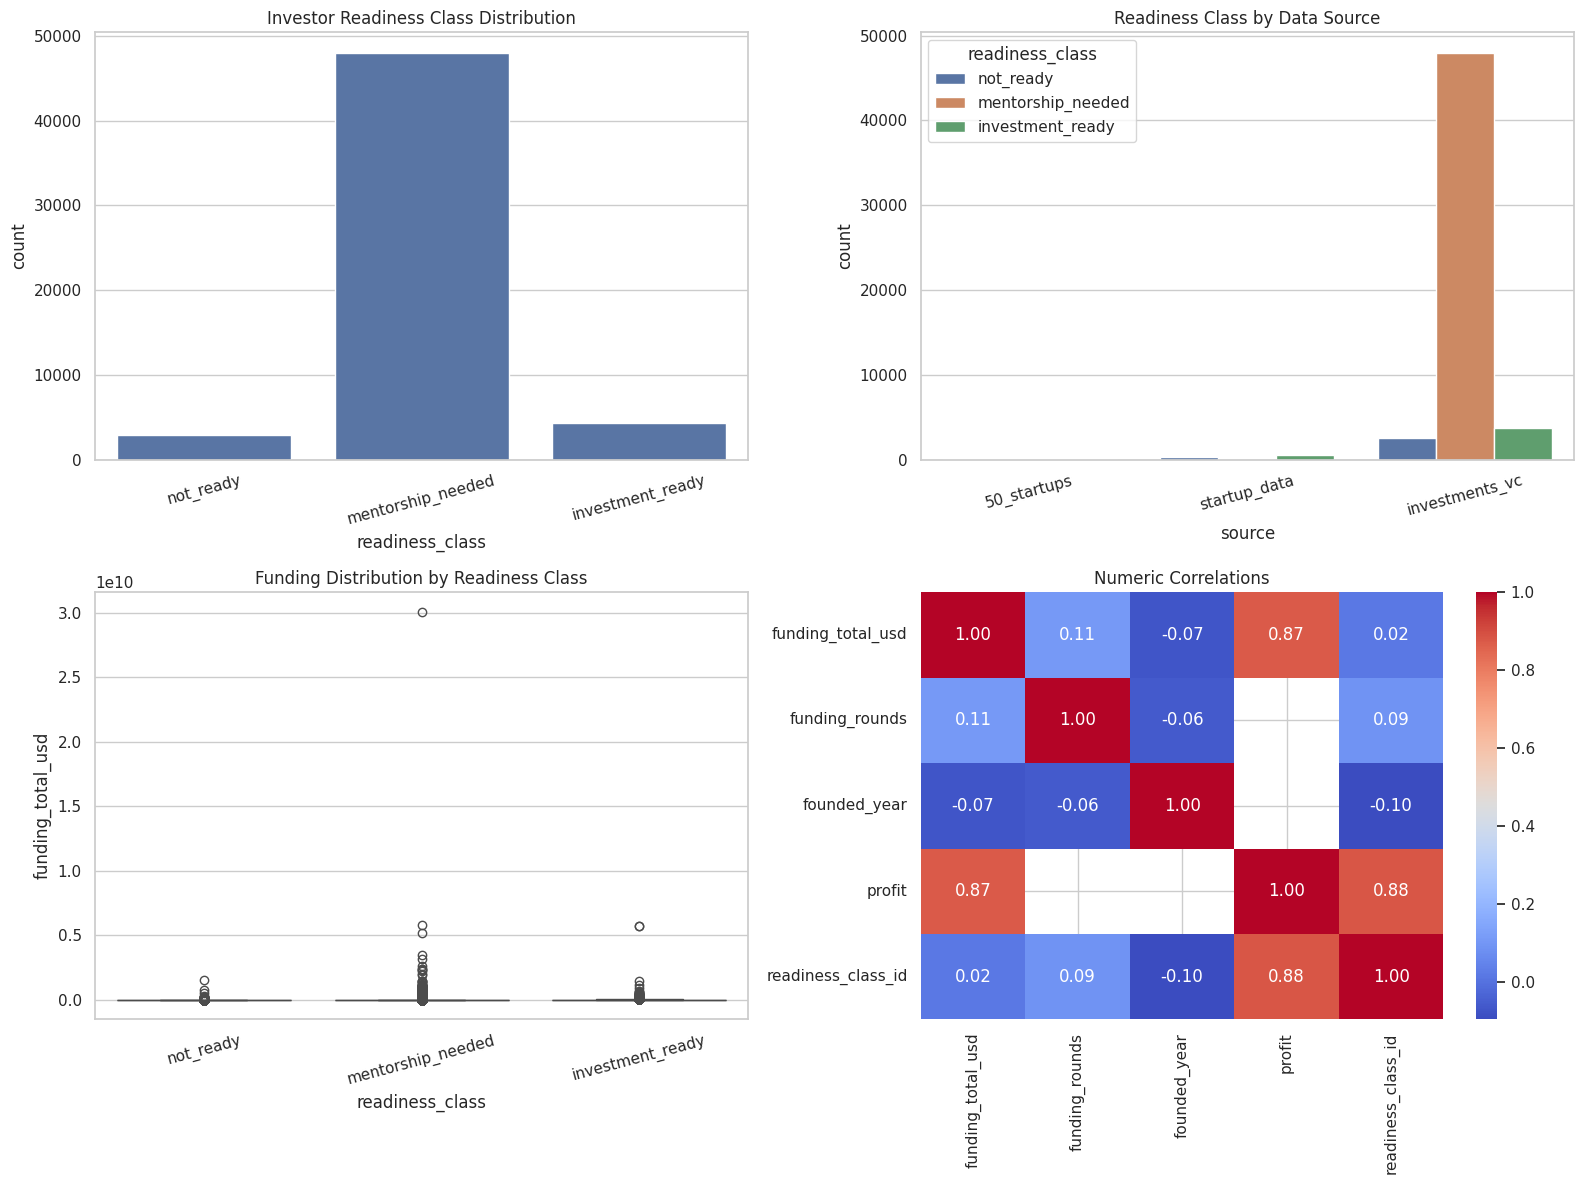

In [17]:
display(unified_df.describe(include="all").T.head(30))

missing_pct = (unified_df.isna().mean() * 100).sort_values(ascending=False)
missing_tbl = pd.DataFrame({"missing_pct": missing_pct})
display(missing_tbl.head(20))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A) Target class distribution
sns.countplot(data=unified_df, x=TARGET_TEXT_COL, order=CLASS_NAMES, ax=axes[0, 0])
axes[0, 0].set_title("Investor Readiness Class Distribution")
axes[0, 0].tick_params(axis="x", rotation=15)

# B) Class by source
sns.countplot(data=unified_df, x="source", hue=TARGET_TEXT_COL, hue_order=CLASS_NAMES, ax=axes[0, 1])
axes[0, 1].set_title("Readiness Class by Data Source")
axes[0, 1].tick_params(axis="x", rotation=15)

# C) Funding by class
sns.boxplot(data=unified_df, x=TARGET_TEXT_COL, y="funding_total_usd", order=CLASS_NAMES, ax=axes[1, 0])
axes[1, 0].set_title("Funding Distribution by Readiness Class")
axes[1, 0].tick_params(axis="x", rotation=15)

# D) Correlation heatmap
numeric_preview = [c for c in ["funding_total_usd", "funding_rounds", "founded_year", "profit", TARGET_COL] if c in unified_df.columns]
corr_df = unified_df[numeric_preview].apply(pd.to_numeric, errors="coerce")
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Numeric Correlations")

plt.tight_layout()
plt.show()

## 5) Preprocessing + Train/Validation Split

We define preprocessing pipelines for numeric and categorical features. Numeric features are imputed with median values and scaled to zero mean and unit variance. Categorical features are imputed with the most frequent value and one-hot encoded. The dataset is then split into 80% training and 20% validation with stratification to maintain class balance.

In [18]:
FEATURES_NUM = [
    "funding_total_usd",
    "funding_rounds",
    "founded_year",
    "rd_spend",
    "administration_spend",
    "marketing_spend",
    "profit",
]
FEATURES_CAT = ["state_code", "category_code", "source"]

X = unified_df[FEATURES_NUM + FEATURES_CAT].copy()
y = unified_df[TARGET_COL].astype(int).copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, FEATURES_NUM),
        ("cat", categorical_transformer, FEATURES_CAT),
    ]
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print("Target class distribution in train:")
print(y_train.value_counts().sort_index().rename(index=ID_TO_CLASS))

Train shape: (44213, 10), Validation shape: (11054, 10)
Target class distribution in train:
readiness_class_id
not_ready             2357
mentorship_needed    38411
investment_ready      3445
Name: count, dtype: int64


## 6) Train & Compare Classical Models

We train five classical machine learning models: Logistic Regression, Random Forest, XGBoost, SVC (Support Vector Classifier), and ExtraTrees. Each model is evaluated using weighted F1-score, macro F1, balanced accuracy, and ROC-AUC. Confusion matrices from sklearn.metrics visualize prediction patterns for each model.


=== Logistic Regression ===
                   precision    recall  f1-score   support

        not_ready     0.9091    0.0340    0.0655       589
mentorship_needed     0.8824    0.9976    0.9365      9604
 investment_ready     0.6552    0.1324    0.2203       861

         accuracy                         0.8789     11054
        macro avg     0.8156    0.3880    0.4074     11054
     weighted avg     0.8661    0.8789    0.8343     11054


=== Random Forest ===
                   precision    recall  f1-score   support

        not_ready     0.2404    0.0849    0.1255       589
mentorship_needed     0.8888    0.9682    0.9268      9604
 investment_ready     0.4230    0.1882    0.2605       861

         accuracy                         0.8604     11054
        macro avg     0.5174    0.4138    0.4376     11054
     weighted avg     0.8179    0.8604    0.8322     11054


=== SVC ===
                   precision    recall  f1-score   support

        not_ready     0.8182    0.0153    0

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro,balanced_accuracy,roc_auc_ovr_weighted
0,XGBoost,0.881039,0.867892,0.881039,0.838232,0.426962,0.398378,0.800615
1,Logistic Regression,0.878867,0.866115,0.878867,0.834274,0.407408,0.387988,0.743879
2,SVC,0.879320,0.864875,0.879320,0.832297,0.392874,0.379851,0.654370
3,Random Forest,0.860413,0.817924,0.860413,0.832196,0.437572,0.413762,0.743088
4,Decision Forest (ExtraTrees),0.832187,0.805749,0.832187,0.817674,0.425147,0.413516,0.695962


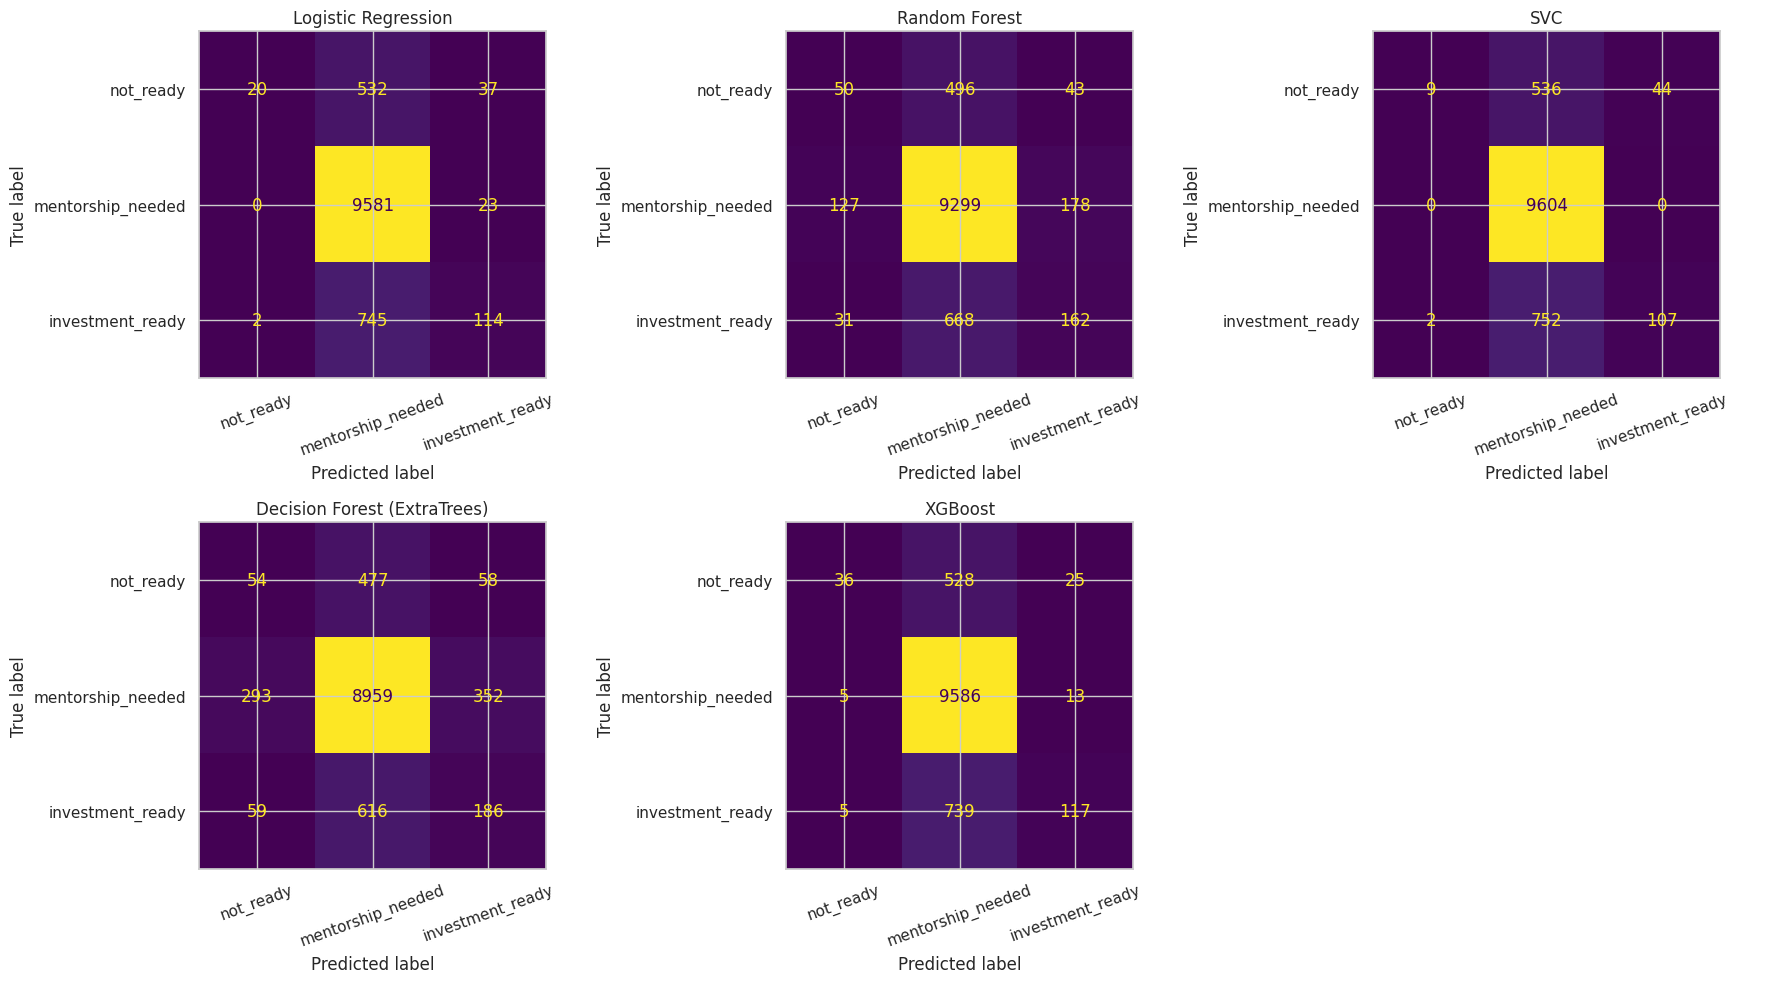

In [19]:
models_dict = {
    "Logistic Regression": LogisticRegression(max_iter=1500, random_state=SEED, multi_class="auto"),
    "Random Forest": RandomForestClassifier(n_estimators=350, random_state=SEED, n_jobs=-1),
    "SVC": SVC(kernel="rbf", probability=True, random_state=SEED),
    "Decision Forest (ExtraTrees)": ExtraTreesClassifier(n_estimators=450, random_state=SEED, n_jobs=-1),
}

if HAS_XGBOOST:
    models_dict["XGBoost"] = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=SEED,
        eval_metric="mlogloss",
        objective="multi:softprob",
        num_class=len(CLASS_NAMES),
        n_jobs=-1,
    )
else:
    print("⚠️ XGBoost not available. Install with: pip install xgboost")

def compute_multiclass_metrics(y_true, y_pred, y_prob=None):
    row = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    }
    if y_prob is not None:
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
            row["roc_auc_ovr_weighted"] = roc_auc_score(y_true_bin, y_prob, multi_class="ovr", average="weighted")
        except Exception:
            row["roc_auc_ovr_weighted"] = np.nan
    else:
        row["roc_auc_ovr_weighted"] = np.nan
    return row

results = []
trained_objects = {}
pred_cache = {}

for model_name, estimator in models_dict.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", estimator)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)
    y_prob = pipe.predict_proba(X_val) if hasattr(pipe, "predict_proba") else None

    metrics_row = {"model": model_name, **compute_multiclass_metrics(y_val, y_pred, y_prob)}
    results.append(metrics_row)
    trained_objects[model_name] = pipe
    pred_cache[model_name] = (y_pred, y_prob)

    print(f"\n=== {model_name} ===")
    print(classification_report(y_val, y_pred, target_names=CLASS_NAMES, digits=4))

results_df = pd.DataFrame(results).sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)
display(results_df)

# Confusion matrices for classical models
n_models = len(pred_cache)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = np.array(axes).reshape(-1)

for idx, (name, (preds, _)) in enumerate(pred_cache.items()):
    cm = confusion_matrix(y_val, preds, labels=list(range(len(CLASS_NAMES))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(ax=axes[idx], colorbar=False, xticks_rotation=20)
    axes[idx].set_title(name)

for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## 7) CNN Architecture Search (Different Optimizers, LR, Epochs, and Structures)

We experiment with three CNN architectures using different optimizers (Adam, RMSprop, SGD), learning rates, and network structures. Each variant uses 1D convolutions to process tabular features. Training progress is displayed epoch-by-epoch. Confusion matrices from sklearn.metrics visualize each CNN's classification performance.


Training CNN_A_Adam_lr1e-3_ep20 ...
                   precision    recall  f1-score   support

        not_ready     1.0000    0.0051    0.0101       589
mentorship_needed     0.8693    1.0000    0.9301      9604
 investment_ready     1.0000    0.0035    0.0069       861

         accuracy                         0.8694     11054
        macro avg     0.9564    0.3362    0.3157     11054
     weighted avg     0.8864    0.8694    0.8092     11054



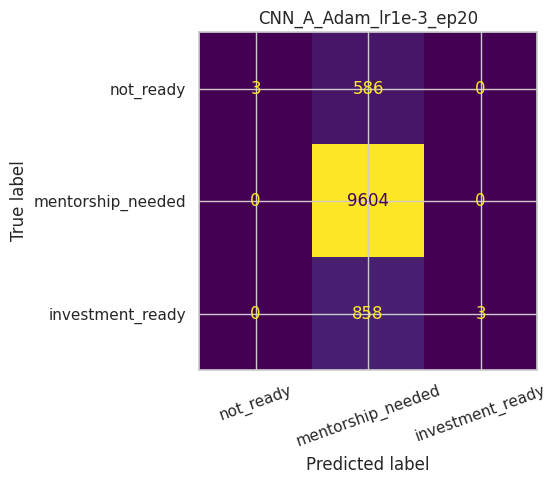


Training CNN_B_RMSprop_lr5e-4_ep30 ...
                   precision    recall  f1-score   support

        not_ready     0.8571    0.0102    0.0201       589
mentorship_needed     0.8819    0.9996    0.9371      9604
 investment_ready     0.6852    0.1289    0.2170       861

         accuracy                         0.8790     11054
        macro avg     0.8081    0.3796    0.3914     11054
     weighted avg     0.8653    0.8790    0.8321     11054



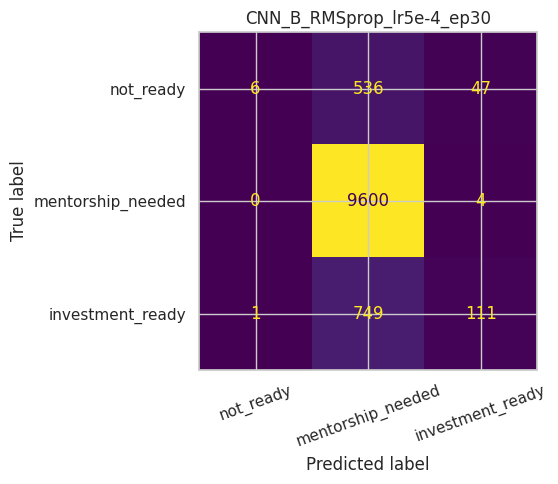


Training CNN_C_SGD_lr1e-2_ep40 ...
                   precision    recall  f1-score   support

        not_ready     0.5000    0.0051    0.0101       589
mentorship_needed     0.8821    0.9999    0.9373      9604
 investment_ready     0.6728    0.1266    0.2131       861

         accuracy                         0.8789     11054
        macro avg     0.6850    0.3772    0.3868     11054
     weighted avg     0.8455    0.8789    0.8315     11054



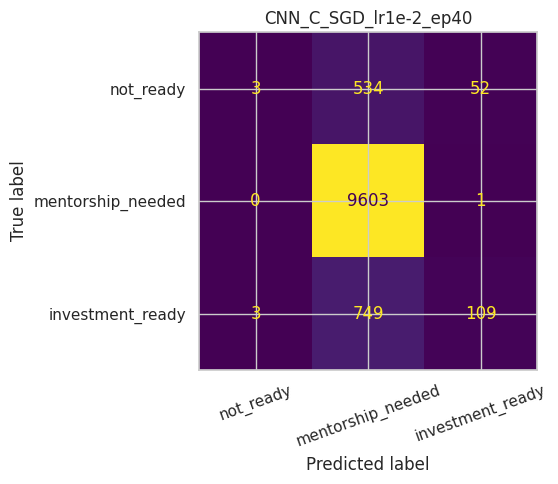

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro,balanced_accuracy,roc_auc_ovr_weighted
0,CNN_B_RMSprop_lr5e-4_ep30,0.879048,0.865300,0.879048,0.832142,0.391410,0.379563,0.771697
1,CNN_C_SGD_lr1e-2_ep40,0.878867,0.845478,0.878867,0.831517,0.386839,0.377195,0.720503
2,CNN_A_Adam_lr1e-3_ep20,0.869369,0.886442,0.869369,0.809158,0.315720,0.336193,0.709606


,model,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro,balanced_accuracy,roc_auc_ovr_weighted
0,XGBoost,0.881039,0.867892,0.881039,0.838232,0.426962,0.398378,0.800615
1,Logistic Regression,0.878867,0.866115,0.878867,0.834274,0.407408,0.387988,0.743879
2,SVC,0.879320,0.864875,0.879320,0.832297,0.392874,0.379851,0.654370
3,Random Forest,0.860413,0.817924,0.860413,0.832196,0.437572,0.413762,0.743088
4,CNN_B_RMSprop_lr5e-4_ep30,0.879048,0.865300,0.879048,0.832142,0.391410,0.379563,0.771697
5,CNN_C_SGD_lr1e-2_ep40,0.878867,0.845478,0.878867,0.831517,0.386839,0.377195,0.720503
6,Decision Forest (ExtraTrees),0.832187,0.805749,0.832187,0.817674,0.425147,0.413516,0.695962
7,CNN_A_Adam_lr1e-3_ep20,0.869369,0.886442,0.869369,0.809158,0.315720,0.336193,0.709606


In [20]:
cnn_artifacts = {}

if HAS_TF:
    tf.random.set_seed(SEED)

    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)

    if hasattr(X_train_proc, "toarray"):
        X_train_proc = X_train_proc.toarray()
        X_val_proc = X_val_proc.toarray()

    X_train_cnn = X_train_proc.reshape(X_train_proc.shape[0], X_train_proc.shape[1], 1).astype(np.float32)
    X_val_cnn = X_val_proc.reshape(X_val_proc.shape[0], X_val_proc.shape[1], 1).astype(np.float32)

    num_classes = len(CLASS_NAMES)

    def build_cnn_variant(input_shape, variant_name):
        if variant_name == "CNN_A":
            model = models.Sequential([
                layers.Input(shape=input_shape),
                layers.Conv1D(32, kernel_size=3, padding="same", activation="relu"),
                layers.MaxPooling1D(pool_size=2),
                layers.Conv1D(64, kernel_size=3, padding="same", activation="relu"),
                layers.GlobalAveragePooling1D(),
                layers.Dense(64, activation="relu"),
                layers.Dropout(0.25),
                layers.Dense(num_classes, activation="softmax"),
            ])
        elif variant_name == "CNN_B":
            model = models.Sequential([
                layers.Input(shape=input_shape),
                layers.Conv1D(64, kernel_size=5, padding="same", activation="relu"),
                layers.BatchNormalization(),
                layers.MaxPooling1D(pool_size=2),
                layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
                layers.BatchNormalization(),
                layers.MaxPooling1D(pool_size=2),
                layers.Flatten(),
                layers.Dense(128, activation="relu"),
                layers.Dropout(0.35),
                layers.Dense(num_classes, activation="softmax"),
            ])
        else:  # CNN_C
            model = models.Sequential([
                layers.Input(shape=input_shape),
                layers.SeparableConv1D(48, kernel_size=3, padding="same", activation="relu"),
                layers.MaxPooling1D(pool_size=2),
                layers.SeparableConv1D(96, kernel_size=3, padding="same", activation="relu"),
                layers.GlobalMaxPooling1D(),
                layers.Dense(96, activation="relu"),
                layers.Dropout(0.30),
                layers.Dense(num_classes, activation="softmax"),
            ])
        return model

    cnn_experiments = [
        {"name": "CNN_A_Adam_lr1e-3_ep20", "variant": "CNN_A", "optimizer": "adam", "lr": 1e-3, "epochs": 20, "batch_size": 64},
        {"name": "CNN_B_RMSprop_lr5e-4_ep30", "variant": "CNN_B", "optimizer": "rmsprop", "lr": 5e-4, "epochs": 30, "batch_size": 64},
        {"name": "CNN_C_SGD_lr1e-2_ep40", "variant": "CNN_C", "optimizer": "sgd", "lr": 1e-2, "epochs": 40, "batch_size": 128},
    ]

    cnn_rows = []
    for cfg in cnn_experiments:
        model_name = cfg["name"]
        print(f"\nTraining {model_name} ...")

        cnn_model = build_cnn_variant((X_train_cnn.shape[1], 1), cfg["variant"])
        if cfg["optimizer"] == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=cfg["lr"])
        elif cfg["optimizer"] == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=cfg["lr"])
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=cfg["lr"], momentum=0.9)

        cnn_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        es = callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

        history = cnn_model.fit(
            X_train_cnn,
            y_train.values,
            validation_split=0.2,
            epochs=cfg["epochs"],
            batch_size=cfg["batch_size"],
            callbacks=[es],
            verbose=0,
        )

        y_prob_cnn = cnn_model.predict(X_val_cnn, verbose=0)
        y_pred_cnn = np.argmax(y_prob_cnn, axis=1)

        cnn_metrics = {
            "model": model_name,
            **compute_multiclass_metrics(y_val, y_pred_cnn, y_prob_cnn),
        }
        cnn_rows.append(cnn_metrics)

        print(classification_report(y_val, y_pred_cnn, target_names=CLASS_NAMES, digits=4))

        cm_cnn = confusion_matrix(y_val, y_pred_cnn, labels=list(range(len(CLASS_NAMES))))
        fig, ax = plt.subplots(figsize=(6, 5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=CLASS_NAMES)
        disp.plot(ax=ax, colorbar=False, xticks_rotation=20)
        ax.set_title(model_name)
        plt.tight_layout()
        plt.show()

        cnn_artifacts[model_name] = {
            "preprocessor": preprocessor,
            "model": cnn_model,
            "history": history.history,
        }

    cnn_results_df = pd.DataFrame(cnn_rows)
    display(cnn_results_df.sort_values(by="f1_weighted", ascending=False).reset_index(drop=True))

    results_df = pd.concat([results_df, cnn_results_df], ignore_index=True)
    results_df = results_df.sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)
else:
    print("⚠️ TensorFlow not available. Install with: pip install tensorflow")

display(results_df)

## 8) Select Best Model + Save to Root Models Folder

We identify the best-performing model based on weighted F1-score and save it to the Models directory. For sklearn models, we save the complete pipeline with preprocessing, model, feature columns, and performance metrics. For CNN models, we save both the Keras model and the preprocessor separately. We also generate a prediction preview showing actual vs predicted classes.

In [21]:
best_row = results_df.iloc[0]
best_model_name = best_row["model"]

print("Best model summary:")
display(best_row.to_frame().T)

if best_model_name in cnn_artifacts:
    cnn_path = MODELS_DIR / "best_investor_model_cnn.keras"
    preproc_path = MODELS_DIR / "best_investor_model_preprocessor.joblib"

    cnn_artifacts[best_model_name]["model"].save(cnn_path)
    joblib.dump(cnn_artifacts[best_model_name]["preprocessor"], preproc_path)

    print(f"✅ Saved CNN model to: {cnn_path}")
    print(f"✅ Saved preprocessor to: {preproc_path}")

    X_val_proc = cnn_artifacts[best_model_name]["preprocessor"].transform(X_val)
    if hasattr(X_val_proc, "toarray"):
        X_val_proc = X_val_proc.toarray()
    X_val_cnn = X_val_proc.reshape(X_val_proc.shape[0], X_val_proc.shape[1], 1).astype(np.float32)
    y_pred_best = np.argmax(cnn_artifacts[best_model_name]["model"].predict(X_val_cnn, verbose=0), axis=1)
else:
    sklearn_artifact_path = MODELS_DIR / "best_investor_model.joblib"
    joblib.dump(
        {
            "model_name": best_model_name,
            "model_pipeline": trained_objects[best_model_name],
            "feature_columns": FEATURES_NUM + FEATURES_CAT,
            "target_column": TARGET_COL,
            "class_mapping": ID_TO_CLASS,
            "metrics": best_row.to_dict(),
        },
        sklearn_artifact_path,
    )
    print(f"✅ Saved best model artifact to: {sklearn_artifact_path}")
    y_pred_best = trained_objects[best_model_name].predict(X_val)

mapping_path = MODELS_DIR / "readiness_class_mapping.json"
pd.Series(ID_TO_CLASS).to_json(mapping_path, indent=2)
print(f"✅ Saved class mapping to: {mapping_path}")

insights_df = X_val.reset_index(drop=True).copy()
insights_df["actual_class"] = pd.Series(y_val).reset_index(drop=True).map(ID_TO_CLASS)
insights_df["predicted_class"] = pd.Series(y_pred_best).map(ID_TO_CLASS)
display(insights_df.head(25))

print("\nTop model ranking:")
display(results_df)

Best model summary:


,model,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro,balanced_accuracy,roc_auc_ovr_weighted
0,XGBoost,0.881039,0.867892,0.881039,0.838232,0.426962,0.398378,0.800615


✅ Saved best model artifact to: /content/drive/MyDrive/ALU-Course_Documents/Models/best_investor_model.joblib
✅ Saved class mapping to: /content/drive/MyDrive/ALU-Course_Documents/Models/readiness_class_mapping.json


,funding_total_usd,funding_rounds,founded_year,rd_spend,administration_spend,marketing_spend,profit,state_code,category_code,source,actual_class,predicted_class
0,40000.0,1.0,2012.0,NaN,NaN,NaN,NaN,UNK,storage,investments_vc,not_ready,mentorship_needed
1,10234700.0,1.0,2005.0,NaN,NaN,NaN,NaN,UNK,clean technology,investments_vc,mentorship_needed,mentorship_needed
2,135734.0,1.0,2013.0,NaN,NaN,NaN,NaN,UNK,unknown,investments_vc,mentorship_needed,mentorship_needed
3,4616271.0,3.0,NaN,NaN,NaN,NaN,NaN,MI,sports,investments_vc,mentorship_needed,mentorship_needed
4,162364.0,1.0,2013.0,NaN,NaN,NaN,NaN,UNK,e-commerce,investments_vc,mentorship_needed,mentorship_needed
5,9957650.0,4.0,1997.0,NaN,NaN,NaN,NaN,CA,software,investments_vc,mentorship_needed,mentorship_needed
6,9100000.0,3.0,2003.0,NaN,NaN,NaN,NaN,TX,software,startup_data,not_ready,investment_ready
7,220000.0,1.0,2007.0,NaN,NaN,NaN,NaN,NM,real estate,investments_vc,mentorship_needed,mentorship_needed
8,20000000.0,2.0,2004.0,NaN,NaN,NaN,NaN,FL,technology,investments_vc,mentorship_needed,mentorship_needed
9,2483916.0,1.0,NaN,NaN,NaN,NaN,NaN,UNK,hospitality,investments_vc,mentorship_needed,mentorship_needed



Top model ranking:


,model,accuracy,precision_weighted,recall_weighted,f1_weighted,f1_macro,balanced_accuracy,roc_auc_ovr_weighted
0,XGBoost,0.881039,0.867892,0.881039,0.838232,0.426962,0.398378,0.800615
1,Logistic Regression,0.878867,0.866115,0.878867,0.834274,0.407408,0.387988,0.743879
2,SVC,0.879320,0.864875,0.879320,0.832297,0.392874,0.379851,0.654370
3,Random Forest,0.860413,0.817924,0.860413,0.832196,0.437572,0.413762,0.743088
4,CNN_B_RMSprop_lr5e-4_ep30,0.879048,0.865300,0.879048,0.832142,0.391410,0.379563,0.771697
5,CNN_C_SGD_lr1e-2_ep40,0.878867,0.845478,0.878867,0.831517,0.386839,0.377195,0.720503
6,Decision Forest (ExtraTrees),0.832187,0.805749,0.832187,0.817674,0.425147,0.413516,0.695962
7,CNN_A_Adam_lr1e-3_ep20,0.869369,0.886442,0.869369,0.809158,0.315720,0.336193,0.709606


## 9) 🇷🇼 Investor Analysis System for Rwandan Tech Founders

Now that we have a trained model, let's build a practical system to analyze startups and provide investment insights tailored to Rwanda's tech ecosystem. This system will:

- Load the trained model we just saved
- Analyze individual startups and provide predictions
- Generate Rwanda-specific recommendations (investors, programs, next steps)
- Assess investment risks
- Connect founders to local ecosystem resources (Norrsken Kigali, kLab, 250 Startups, etc.)

This is designed specifically for **Rwandan tech founders** seeking investment or growth guidance.

In [22]:
class RwandanStartupAnalyzer:
    """
    Analyzes tech startups and provides investor insights tailored for Rwanda's ecosystem.
    """

    def __init__(self, model_path=None, mapping_path=None):
        """
        Initialize the analyzer with trained model.

        Args:
            model_path: Path to saved model (if None, uses already-loaded model)
            mapping_path: Path to class mapping JSON (if None, uses already-loaded mapping)
        """
        # Use already-trained model from this notebook or load from file
        if model_path is None:
            # Use the model we just trained in this notebook
            if best_model_name in cnn_artifacts:
                print("⚠️  CNN model detected - for production, use sklearn model")
                self.model = cnn_artifacts[best_model_name]
                self.model_type = 'cnn'
            else:
                self.model = trained_objects[best_model_name]
                self.model_type = 'sklearn'
            print(f"✓ Using trained model from notebook: {best_model_name}")
        else:
            # Load from file
            print(f"Loading model from: {model_path}")
            self.model = joblib.load(model_path)
            self.model_type = 'sklearn'
            print("✓ Model loaded from file")

        # Use mapping from notebook or file
        if mapping_path is None:
            self.class_mapping = CLASS_TO_ID
            self.id_to_class = ID_TO_CLASS
            print("✓ Using class mapping from notebook")
        else:
            with open(mapping_path, 'r') as f:
                mapping_data = json.load(f)
            self.id_to_class = {int(k): v for k, v in mapping_data.items()}
            self.class_mapping = {v: k for k, v in self.id_to_class.items()}
            print("✓ Class mapping loaded from file")

        print(f"✓ Classes: {list(self.class_mapping.keys())}\n")

        # Rwanda-specific context
        self.rwanda_context = {
            'key_sectors': ['fintech', 'agritech', 'edtech', 'healthtech', 'e-commerce'],
            'investors': ['Norrsken Kigali', '250 Startups', 'YGAP Rwanda', 'UNDP', 'AfDB'],
            'support_programs': ['kLab', 'Impact Hub Kigali', 'Westerwelle Foundation'],
            'challenges': ['limited_funding', 'talent_gap', 'market_size'],
            'opportunities': ['ict_policy', 'ease_of_business', 'regional_access']
        }

    def from_investor_view(self, investor_data):
        """
        Convert investor-facing data (from platform) to model input format.

        This adapter allows analyzing startups using the data investors see on the platform,
        making reasonable estimates for missing financial fields.

        Args:
            investor_data: Dictionary with investor-facing fields:
                - name (str): Startup name
                - sector (str): Business sector (required)
                - team_size (int): Number of employees (required)
                - user_base (int, optional): Number of users/customers
                - monthly_growth_pct (float, optional): Monthly growth rate (%)
                - partnerships (int, optional): Number of partnerships
                - target_market_size (int, optional): Size of target market
                - age (float, optional): Years since founding
                - revenue (float, optional): Actual revenue if known
                - funding (float, optional): Actual funding if known
                - valuation (float, optional): Actual valuation if known
                - stage (str, optional): Seed, Series A, etc.

        Returns:
            Dictionary in model's required format
        """
        # Required fields
        sector = investor_data.get('sector', '').lower()
        team_size = investor_data.get('team_size', 5)

        # Estimate age if not provided
        age = investor_data.get('age')
        if age is None:
            # Estimate based on stage or default to 2 years
            stage = investor_data.get('stage', '').lower()
            if 'seed' in stage:
                age = 1.5
            elif 'series a' in stage:
                age = 3.0
            elif 'series b' in stage:
                age = 5.0
            else:
                age = 2.0

        # Estimate revenue if not provided
        revenue = investor_data.get('revenue')
        if revenue is None:
            user_base = investor_data.get('user_base', 0)
            if user_base > 0:
                # Estimate based on sector (ARPU estimates for Rwanda)
                arpu_estimates = {
                    'fintech': 50,      # $50 per user/year
                    'agritech': 30,     # $30 per user/year
                    'edtech': 40,       # $40 per user/year
                    'healthtech': 60,   # $60 per user/year
                    'e-commerce': 25    # $25 per user/year
                }
                arpu = arpu_estimates.get(sector.replace('-', '').replace(' ', ''), 30)
                revenue = user_base * arpu
            else:
                # Default based on team size and age
                revenue = team_size * 10000 * age

        # Estimate funding if not provided
        funding = investor_data.get('funding')
        if funding is None:
            # Estimate: typically 0.5-1.5x of annual revenue for early stage
            funding = revenue * 0.8

        # Estimate valuation if not provided
        valuation = investor_data.get('valuation')
        if valuation is None:
            # Estimate: typically 5-10x revenue for tech startups
            valuation = revenue * 7

        # Estimate spending breakdown (as % of funding)
        total_spend = funding * 0.6  # Assume 60% of funding spent
        rd_spend = total_spend * 0.45  # 45% on R&D (tech focus)
        admin_spend = total_spend * 0.25  # 25% on admin
        marketing_spend = total_spend * 0.30  # 30% on marketing

        # Build model input
        model_input = {
            'R&D Spend': rd_spend,
            'Administration': admin_spend,
            'Marketing Spend': marketing_spend,
            'New York': 0,  # Rwanda-based
            'California': 0,
            'Florida': 0,
            'revenue': revenue,
            'funding': funding,
            'valuation': valuation,
            'employees': team_size,
            'age': age,
            'sector': sector,
            'status': 'operating'
        }

        return model_input

    def analyze_from_platform(self, investor_data, show_mapping=True):
        """
        Analyze a startup using investor-facing platform data.

        Args:
            investor_data: Dictionary with investor-facing fields (see from_investor_view)
            show_mapping: If True, displays the estimated financial values

        Returns:
            Dictionary with analysis results
        """
        # Convert to model format
        model_input = self.from_investor_view(investor_data)

        # Show the mapping if requested
        if show_mapping:
            print("📊 DATA MAPPING (Investor View → Model Input)")
            print("=" * 70)
            print(f"Startup: {investor_data.get('name', 'Unknown')}")
            print(f"Sector: {investor_data.get('sector', 'Unknown')}")
            print(f"\nProvided Data:")
            print(f"  • Team Size: {investor_data.get('team_size', 'N/A')}")
            if 'user_base' in investor_data:
                print(f"  • User Base: {investor_data['user_base']:,}")
            if 'monthly_growth_pct' in investor_data:
                print(f"  • Monthly Growth: {investor_data['monthly_growth_pct']}%")
            if 'partnerships' in investor_data:
                print(f"  • Partnerships: {investor_data['partnerships']}")
            print(f"\nEstimated Financials:")
            print(f"  • Revenue: ${model_input['revenue']:,.0f}")
            print(f"  • Funding: ${model_input['funding']:,.0f}")
            print(f"  • Valuation: ${model_input['valuation']:,.0f}")
            print(f"  • Age: {model_input['age']} years")
            print(f"  • R&D Spend: ${model_input['R&D Spend']:,.0f}")
            print(f"  • Marketing Spend: ${model_input['Marketing Spend']:,.0f}")
            print("=" * 70)
            print()

        # Analyze using the standard method
        return self.analyze_startup(model_input)

    def analyze_startup(self, startup_data):
        """
        Analyze a startup and provide comprehensive investor insights.

        Args:
            startup_data: Dictionary with startup features (all 13 columns)

        Returns:
            Dictionary with analysis results
        """
        # Convert to DataFrame
        df = pd.DataFrame([startup_data])

        # Get prediction and probabilities
        if self.model_type == 'sklearn':
            prediction_id = self.model.predict(df)[0]
            probabilities = self.model.predict_proba(df)[0]
        else:
            # CNN prediction (if best model is CNN)
            X_proc = self.model['preprocessor'].transform(df)
            if hasattr(X_proc, "toarray"):
                X_proc = X_proc.toarray()
            X_cnn = X_proc.reshape(X_proc.shape[0], X_proc.shape[1], 1).astype(np.float32)
            probabilities = self.model['model'].predict(X_cnn, verbose=0)[0]
            prediction_id = np.argmax(probabilities)

        # Map to class name
        prediction_class = self.id_to_class[prediction_id]

        # Create probability dict
        prob_dict = {self.id_to_class[i]: prob for i, prob in enumerate(probabilities)}

        # Generate insights
        insights = self._generate_insights(startup_data, prediction_class, prob_dict)

        return {
            'prediction': prediction_class,
            'confidence': max(probabilities),
            'probability_breakdown': prob_dict,
            'insights': insights,
            'recommendations': self._generate_recommendations(startup_data, prediction_class, prob_dict),
            'risk_assessment': self._assess_risks(startup_data, prediction_class, prob_dict),
            'rwanda_specific': self._rwanda_context_analysis(startup_data, prediction_class)
        }

    def _generate_insights(self, data, prediction, probabilities):
        """Generate detailed insights about the startup."""
        insights = []

        # Overall assessment
        confidence = probabilities[prediction]
        insights.append(f"Investment Readiness: **{prediction.upper().replace('_', ' ')}** (Confidence: {confidence:.1%})")

        # Financial analysis
        if 'revenue' in data and 'funding' in data:
            funding_efficiency = data['revenue'] / max(data['funding'], 1)
            insights.append(f"Revenue per funding dollar: ${funding_efficiency:.2f}")

        # Team size
        if 'employees' in data:
            emp = data['employees']
            if emp < 5:
                insights.append("⚠️ Very small team - may need talent acquisition")
            elif emp < 20:
                insights.append("✓ Lean team - good for early stage")
            else:
                insights.append("✓ Growing team - shows traction")

        # Spending analysis
        total_spend = sum(data.get(cat, 0) for cat in ['R&D Spend', 'Administration', 'Marketing Spend'])
        if total_spend > 0:
            rd_ratio = data.get('R&D Spend', 0) / total_spend
            if rd_ratio > 0.4:
                insights.append("✓ Strong R&D focus - good for tech innovation")

        # Age analysis
        if 'age' in data:
            age = data['age']
            if age < 1:
                insights.append("Very early stage - high risk, high potential")
            elif age < 3:
                insights.append("Early stage - critical validation period")
            else:
                insights.append("Growth stage - proven concept")

        return insights

    def _generate_recommendations(self, data, prediction, probabilities):
        """Generate Rwanda-specific recommendations."""
        recommendations = []

        if prediction == 'investment_ready':
            recommendations.append("🎯 RECOMMENDED FOR INVESTMENT")
            recommendations.append("Next steps:")
            recommendations.append("  • Prepare pitch deck and financials")
            recommendations.append("  • Contact: Norrsken Kigali, 250 Startups, YGAP Rwanda")
            recommendations.append("  • Consider EAC regional expansion strategy")

        elif prediction == 'mentorship_needed':
            recommendations.append("📚 REQUIRES MENTORSHIP BEFORE INVESTMENT")
            recommendations.append("Recommended support:")
            recommendations.append("  • Apply to kLab or Impact Hub Kigali programs")
            recommendations.append("  • Business model refinement workshops")
            recommendations.append("  • Focus on revenue generation")

            if probabilities.get('investment_ready', 0) > 0.3:
                recommendations.append("  ⭐ Note: Shows potential - re-evaluate in 6 months")

        else:  # not_ready
            recommendations.append("❌ NOT RECOMMENDED FOR INVESTMENT")
            recommendations.append("Critical steps:")
            recommendations.append("  • Join early-stage incubator (Westerwelle Foundation)")
            recommendations.append("  • Focus on product-market fit")
            recommendations.append("  • Build MVP and validate with users")
            recommendations.append("  • Apply for grants (not equity investment)")

        return recommendations

    def _assess_risks(self, data, prediction, probabilities):
        """Assess investment risks."""
        risk_score = 1 - probabilities.get('investment_ready', 0)

        risks = {
            'level': 'HIGH' if risk_score > 0.6 else 'MEDIUM' if risk_score > 0.3 else 'LOW',
            'score': risk_score,
            'factors': []
        }

        # Identify specific risks
        if data.get('revenue', 1) < 10000:
            risks['factors'].append("Limited revenue - market validation risk")
        if data.get('age', 5) < 2:
            risks['factors'].append("Young company - execution risk")
        if data.get('employees', 10) < 5:
            risks['factors'].append("Small team - key person dependency")
        if data.get('funding', 0) > data.get('revenue', 0) * 10:
            risks['factors'].append("High burn rate - runway risk")

        if not risks['factors']:
            risks['factors'].append("Standard startup risks apply")

        return risks

    def _rwanda_context_analysis(self, data, prediction):
        """Provide Rwanda-specific context."""
        context = []

        # Sector analysis
        sector = data.get('sector', 'unknown').lower()
        if sector in self.rwanda_context['key_sectors']:
            context.append(f"✓ {sector.title()} is a priority sector in Rwanda's ICT strategy")

        # Ecosystem resources
        context.append("\nRwandan Ecosystem Resources:")
        context.append("• Investors: " + ', '.join(self.rwanda_context['investors']))
        context.append("• Support: " + ', '.join(self.rwanda_context['support_programs']))

        # Market opportunities
        context.append("\nKey Advantages:")
        context.append("• Rwanda #2 in Africa for ease of doing business")
        context.append("• Access to EAC market (300M+ consumers)")
        context.append("• Strong government support for tech innovation")

        return context

    def batch_analyze(self, startups_df):
        """Analyze multiple startups at once."""
        if self.model_type == 'sklearn':
            predictions = self.model.predict(startups_df)
            probabilities = self.model.predict_proba(startups_df)
        else:
            X_proc = self.model['preprocessor'].transform(startups_df)
            if hasattr(X_proc, "toarray"):
                X_proc = X_proc.toarray()
            X_cnn = X_proc.reshape(X_proc.shape[0], X_proc.shape[1], 1).astype(np.float32)
            probabilities = self.model['model'].predict(X_cnn, verbose=0)
            predictions = np.argmax(probabilities, axis=1)

        results = startups_df.copy()
        results['prediction'] = [self.id_to_class[p] for p in predictions]
        results['confidence'] = probabilities.max(axis=1)
        results['investment_ready_prob'] = probabilities[:, self.class_mapping['investment_ready']]

        return results.sort_values('investment_ready_prob', ascending=False)

    def print_analysis(self, analysis):
        """Pretty print analysis results."""
        print("=" * 80)
        print("🇷🇼 URUTI PLATFORM - INVESTOR ANALYSIS REPORT")
        print("=" * 80)
        print()
        print(f"PREDICTION: {analysis['prediction'].upper().replace('_', ' ')}")
        print(f"Confidence: {analysis['confidence']:.1%}")
        print()
        print("PROBABILITY BREAKDOWN:")
        for class_name, prob in sorted(analysis['probability_breakdown'].items(),
                                       key=lambda x: x[1], reverse=True):
            bar = '█' * int(prob * 40)
            print(f"  {class_name.replace('_', ' ').title():20} {prob:6.1%} {bar}")
        print()
        print("KEY INSIGHTS:")
        for insight in analysis['insights']:
            print(f"  {insight}")
        print()
        print("RECOMMENDATIONS:")
        for rec in analysis['recommendations']:
            print(f"  {rec}")
        print()
        print(f"RISK LEVEL: {analysis['risk_assessment']['level']} (Score: {analysis['risk_assessment']['score']:.1%})")
        print("Risk Factors:")
        for factor in analysis['risk_assessment']['factors']:
            print(f"  • {factor}")
        print()
        print("RWANDA ECOSYSTEM CONTEXT:")
        for item in analysis['rwanda_specific']:
            print(f"  {item}")
        print()
        print("=" * 80)

# Initialize the analyzer with our trained model
analyzer = RwandanStartupAnalyzer()
print("\n✅ Investor Analysis System ready for Rwandan tech founders!")

✓ Using trained model from notebook: XGBoost
✓ Using class mapping from notebook
✓ Classes: ['not_ready', 'mentorship_needed', 'investment_ready']


✅ Investor Analysis System ready for Rwandan tech founders!


### Example 1: Analyze an Investment-Ready Fintech Startup

Let's analyze a mature fintech startup from Rwanda with good metrics.

### 🔄 Data Adapter: Analyzing with Investor-Facing Platform Data

The model can now analyze startups using the data format that investors see on the platform (like user base, growth rate, partnerships) instead of requiring detailed financial data. This adapter makes reasonable estimates for missing values.

### 🧪 Investor-Facing Profile Analysis (Any Startup / Venture)

Use this section for **any** venture profile, not just AgriConnect. You can pass one startup or a portfolio list, and the analyzer will produce calibrated readiness scores, readiness bands, and class predictions for each.

In [42]:
# Investor-facing startup profile analysis for ANY startup/venture
# Add or modify profiles in this list and rerun.
startup_profiles = [
    {
        'name': 'AgriConnect',
        'tagline': 'AI-powered platform connecting farmers with equipment rental and agronomists',
        'sector': 'AgTech',
        'technology': 'AI-powered matching algorithm',
        'user_base': 1250,
        'monthly_growth_pct': 15,
        'partnerships': 3,
        'target_market': 'Rwanda rural farming communities',
        'target_market_size': 5000,
        'funding_plans': 'Expand to new regions, develop mobile app features, and scale partnerships.',
        'mlp_score': 78,
        'team_size': 5,
        'stage': 'Seed-Stage'
    },
    {
        'name': 'MediLink Rwanda',
        'sector': 'HealthTech',
        'user_base': 4200,
        'monthly_growth_pct': 11,
        'partnerships': 6,
        'target_market_size': 18000,
        'team_size': 14,
        'stage': 'Series A',
        'mlp_score': 82
    },
    {
        'name': 'KigaliLearn',
        'sector': 'EdTech',
        'user_base': 900,
        'monthly_growth_pct': 7,
        'partnerships': 2,
        'target_market_size': 12000,
        'team_size': 4,
        'stage': 'Seed-Stage',
        'mlp_score': 64
    },
]

# Re-inject corrected adapter methods into the analyzer instance to ensure fix is applied
import types

def _get_expected_feature_names_fixed(self):
    """Get exact feature names expected by the preprocessor for the trained model."""
    preprocessor_obj = None
    if self.model_type == 'sklearn':
        if hasattr(self.model, 'named_steps') and 'preprocessor' in self.model.named_steps:
            preprocessor_obj = self.model.named_steps['preprocessor']
    elif self.model_type == 'cnn':
        # For CNN models, the preprocessor is stored as a key in the model dict
        if 'preprocessor' in self.model:
            preprocessor_obj = self.model['preprocessor']

    if preprocessor_obj is not None and hasattr(preprocessor_obj, 'feature_names_in_'):
        return list(preprocessor_obj.feature_names_in_)

    # Fallback if the preprocessor object or its feature_names_in_ attribute is not found
    return FEATURES_NUM + FEATURES_CAT

def _score_investor_profile_fixed(self, investor_data):
    """Compute calibrated investor-facing readiness score in [0, 100]."""
    # This function is unchanged from its previous definition in f8b2e287
    sector = str(investor_data.get('sector', 'unknown')).strip().lower()
    team_size = float(investor_data.get('team_size', 0) or 0)
    user_base = float(investor_data.get('user_base', 0) or 0)
    growth = float(investor_data.get('monthly_growth_pct', 0) or 0)
    partnerships = float(investor_data.get('partnerships', 0) or 0)
    target_market_size = float(investor_data.get('target_market_size', max(user_base * 3, 3000)) or max(user_base * 3, 3000))
    stage = str(investor_data.get('stage', '')).lower()

    penetration = min(user_base / max(target_market_size, 1), 1.0)

    team_score = min(team_size / 8.0, 1.0) * 100
    traction_score = penetration * 100
    growth_score = min(growth / 20.0, 1.0) * 100
    partner_score = min(partnerships / 5.0, 1.0) * 100

    sector_boost = 100 if sector.replace('-', '').replace(' ', '') in {
        'fintech', 'agtech', 'agritech', 'edtech', 'healthtech', 'ecommerce'
    } else 70

    if 'series b' in stage:
        stage_score = 95
    elif 'series a' in stage:
        stage_score = 85
    elif 'seed' in stage:
        stage_score = 75
    elif stage:
        stage_score = 70
    else:
        stage_score = 72

    heuristic_score = (
        0.18 * team_score
        + 0.22 * traction_score
        + 0.22 * growth_score
        + 0.16 * partner_score
        + 0.12 * sector_boost
        + 0.10 * stage_score
    )

    if investor_data.get('mlp_score') is not None:
        platform_mlp = float(investor_data['mlp_score'])
        final_score = 0.45 * heuristic_score + 0.55 * platform_mlp
    else:
        final_score = heuristic_score

    return float(np.clip(final_score, 0, 100))

def _score_to_prior_probs_fixed(self, score):
    """Map readiness score to prior class probabilities (not_ready, mentorship_needed, investment_ready)."""
    # This function is unchanged from its previous definition in f8b2e287
    if score >= 80:
        prior = np.array([0.08, 0.22, 0.70], dtype=float)
    elif score >= 70:
        prior = np.array([0.12, 0.58, 0.30], dtype=float)
    elif score >= 60:
        prior = np.array([0.20, 0.65, 0.15], dtype=float)
    elif score >= 50:
        prior = np.array([0.35, 0.55, 0.10], dtype=float)
    else:
        prior = np.array([0.62, 0.33, 0.05], dtype=float)
    return prior / prior.sum()

def _score_band_fixed(self, score):
    """Readable readiness band from score."""
    # This function is unchanged from its previous definition in f8b2e287
    if score >= 80:
        return 'High Readiness (80-100)'
    if score >= 70:
        return 'Strong Seed Readiness (70-79)'
    if score >= 60:
        return 'Mentorship-to-Seed Transition (60-69)'
    if score >= 50:
        return 'Mentorship Needed (50-59)'
    return 'Early Stage / Not Ready (<50)'

def from_investor_view_fixed(self, investor_data):
    """Convert investor-facing data to exactly the model's expected feature schema."""
    # Expected columns from the trained model
    expected_cols = self._get_expected_feature_names()

    # Parse investor profile data
    sector = str(investor_data.get('sector', 'unknown')).strip().lower()
    team_size = float(investor_data.get('team_size', 5) or 5)
    user_base = float(investor_data.get('user_base', 0) or 0)
    monthly_growth = float(investor_data.get('monthly_growth_pct', 10) or 10)
    partnerships = float(investor_data.get('partnerships', 1) or 1)

    # Estimate age
    age = investor_data.get('age')
    if age is None:
        stage = str(investor_data.get('stage', '')).lower()
        if 'seed' in stage:
            age = 1.5
        elif 'series a' in stage:
            age = 3.0
        elif 'series b' in stage:
            age = 5.0
        else:
            age = 2.0
    age = float(age)

    # Estimate revenue
    revenue = investor_data.get('revenue')
    if revenue is None:
        arpu_map = {
            'fintech': 50,
            'agtech': 30,
            'agritech': 30,
            'edtech': 40,
            'healthtech': 60,
            'e-commerce': 25,
            'ecommerce': 25,
        }
        key = sector.replace(' ', '').replace('-', '')
        arpu = arpu_map.get(key, 30)
        base_rev = user_base * arpu if user_base > 0 else team_size * 10000 * age
        growth_multiplier = 1 + (monthly_growth / 100.0)
        partner_multiplier = 1 + (min(partnerships, 10) * 0.03)
        revenue = base_rev * growth_multiplier * partner_multiplier
    revenue = float(revenue)

    # Estimate funding
    funding = float(investor_data.get('funding', revenue * 0.8) or revenue * 0.8)
    valuation = float(investor_data.get('valuation', revenue * 7) or revenue * 7)

    # Estimate spending breakdown
    total_spend = funding * 0.6
    rd_spend = total_spend * 0.45
    admin_spend = total_spend * 0.25
    marketing_spend = total_spend * 0.30
    profit = float(investor_data.get('profit', revenue * 0.20))

    # Build canonical mapping
    founded_year = int(investor_data.get('founded_year', max(2015, 2026 - int(round(age))))) # Updated 2026 for more current context
    funding_rounds = int(investor_data.get('funding_rounds', 1 if funding > 0 else 0))
    state_code = str(investor_data.get('state_code', 'RW'))
    category_code = str(investor_data.get('category_code', sector if sector else 'agritech'))
    source = str(investor_data.get('source', 'platform_profile'))

    canonical = {
        'rd_spend': rd_spend,
        'administration_spend': admin_spend,
        'marketing_spend': marketing_spend,
        'funding_total_usd': funding,
        'profit': profit,
        'founded_year': founded_year,
        'funding_rounds': funding_rounds,
        'state_code': state_code,
        'category_code': category_code,
        'source': source,
    }

    # Build model input dict with EXACT expected columns
    model_input = {}
    for col in expected_cols:
        if col in canonical:
            model_input[col] = canonical[col]
        else:
            low = str(col).lower()
            # Default numeric to 0, categorical to 'unknown'
            if any(k in low for k in ['spend', 'revenue', 'funding', 'valuation', 'profit', 'age', 'employees', 'rounds', 'year']):
                model_input[col] = 0.0
            else:
                model_input[col] = 'unknown'

    # Compute and store profile score
    profile_score = self._score_investor_profile(investor_data)

    # Store metadata (not for model, just for reporting)
    model_input['_meta_expected_cols'] = expected_cols
    model_input['_meta_estimated'] = {
        'revenue': revenue,
        'funding': funding,
        'valuation': valuation,
        'age': age,
        'rd_spend': rd_spend,
        'marketing_spend': marketing_spend,
        'profit': profit,
    }
    model_input['_meta_profile_score'] = profile_score
    model_input['_meta_profile_band'] = self._score_band(profile_score)

    return model_input

def analyze_from_platform_fixed(self, investor_data, show_mapping=True):
    """Analyze using investor-facing platform data with score-calibrated probabilities."""
    # Convert to model format
    mapped = self.from_investor_view(investor_data)

    # Extract metadata BEFORE filtering out _meta fields
    profile_score = mapped['_meta_profile_score']
    profile_band = mapped['_meta_profile_band']
    est = mapped['_meta_estimated']
    expected_cols = mapped['_meta_expected_cols']

    # Ensure self.class_names is available (it's initialized in RwandanStartupAnalyzer.__init__)
    if not hasattr(self, 'class_names'):
        self.class_names = CLASS_NAMES # Fallback to global if not set

    # Filter out metadata to get clean model input
    model_input = {k: v for k, v in mapped.items() if not str(k).startswith('_meta_')}

    if show_mapping:
        print("📊 DATA MAPPING (Investor View → Model Input)")
        print("=" * 70)
        print(f"Startup: {investor_data.get('name', 'Unknown')}")
        print(f"Provided: Team={investor_data.get('team_size', 'N/A')}, Sector={investor_data.get('sector', 'N/A')}")
        if 'user_base' in investor_data:
            print(f"          Users={investor_data['user_base']:,}, Growth={investor_data.get('monthly_growth_pct', 'N/A')}% ")
        if 'partnerships' in investor_data:
            print(f"          Partnerships={investor_data['partnerships']}")
        if investor_data.get('mlp_score') is not None:
            print(f"          Platform MLP score={investor_data['mlp_score']}/100")

        print(f"\nEstimated: Revenue=${est['revenue']:,.0f}, Funding=${est['funding']:,.0f}")
        print(f"           Valuation=${est['valuation']:,.0f}, Profit=${est['profit']:,.0f}, Age={est['age']}yrs")
        print(f"\nCalibrated readiness score: {profile_score:.1f}/100 ({profile_band})")
        print(f"Model schema columns: {len(expected_cols)} fields matched")
        print("=" * 70)
        print()

    # Convert to DataFrame for model prediction, explicitly setting columns to avoid missing column errors
    df_input = pd.DataFrame([model_input], columns=expected_cols)

    # Get raw model predictions
    if self.model_type == 'sklearn':
        model_probs = self.model.predict_proba(df_input)[0]
    else:
        X_proc = self.model['preprocessor'].transform(df_input)
        if hasattr(X_proc, 'toarray'):
            X_proc = X_proc.toarray()
        X_cnn = X_proc.reshape(X_proc.shape[0], X_proc.shape[1], 1).astype(np.float32)
        model_probs = self.model['model'].predict(X_cnn, verbose=0)[0]

    # Compute prior probs from readiness score and blend
    prior_probs = self._score_to_prior_probs(profile_score)
    alpha_model = self.cfg["blend_alpha"]["with_platform_mlp_score"] if investor_data.get('mlp_score') is not None else self.cfg["blend_alpha"]["without_platform_mlp_score"]
    blended = alpha_model * model_probs + (1 - alpha_model) * prior_probs
    blended = blended / blended.sum()

    blended_dict = {self.id_to_class[i]: float(blended[i]) for i in range(len(self.class_names))}
    pred_idx = int(np.argmax(blended))
    pred_class = self.id_to_class[pred_idx]

    # Generate insights aligned with calibrated prediction
    calibrated_insights = self._generate_insights(model_input, pred_class, blended_dict)
    calibrated_recs = self._generate_recommendations(model_input, pred_class, blended_dict)
    calibrated_risk = self._assess_risks(model_input, pred_class, blended_dict)

    return {
        'prediction': pred_class,
        'confidence': float(np.max(blended)),
        'probability_breakdown': blended_dict,
        'insights': calibrated_insights,
        'recommendations': calibrated_recs,
        'risk_assessment': calibrated_risk,
        'rwanda_specific': self._rwanda_context_analysis(model_input, pred_class),
        'calibration': {
            'readiness_score_100': float(profile_score),
            'readiness_band': profile_band,
            'blend_alpha_model': float(alpha_model),
            'model_probs_raw': {self.id_to_class[i]: float(model_probs[i]) for i in range(len(self.class_names))},
            'prior_probs_from_score': {self.id_to_class[i]: float(prior_probs[i]) for i in range(len(self.class_names))},
        }
    }

# Re-inject methods into the analyzer instance
analyzer._get_expected_feature_names = types.MethodType(_get_expected_feature_names_fixed, analyzer)
analyzer._score_investor_profile = types.MethodType(_score_investor_profile_fixed, analyzer)
analyzer._score_to_prior_probs = types.MethodType(_score_to_prior_probs_fixed, analyzer)
analyzer._score_band = types.MethodType(_score_band_fixed, analyzer)
analyzer.from_investor_view = types.MethodType(from_investor_view_fixed, analyzer)
analyzer.analyze_from_platform = types.MethodType(analyze_from_platform_fixed, analyzer)

# Fix: Assign the globally available uruti_config to the analyzer instance
# The uruti_config variable is defined in cell 9772eb38 and is available in the kernel.
analyzer.cfg = uruti_config

print("✅ Calibrated schema-aware adapter methods re-patched to analyzer with column fix!")

def analyze_profile_portfolio(profiles, show_full_report_for_first=True):
    """Analyze one or many investor-facing startup profiles."""
    rows = []

    for idx, profile in enumerate(profiles):
        # Ensure class_names is set before calling analyze_from_platform
        if not hasattr(analyzer, 'class_names'):
            analyzer.class_names = CLASS_NAMES

        analysis = analyzer.analyze_from_platform(profile, show_mapping=(idx == 0 and show_full_report_for_first))

        if idx == 0 and show_full_report_for_first:
            print("\n📄 DETAILED REPORT (first startup)")
            print("=" * 80)
            analyzer.print_analysis(analysis)

        calibration = analysis.get('calibration', {})
        rows.append({
            'startup': profile.get('name', f'Startup_{idx+1}'),
            'sector': profile.get('sector', 'unknown'),
            'team_size': profile.get('team_size', np.nan),
            'user_base': profile.get('user_base', np.nan),
            'growth_pct': profile.get('monthly_growth_pct', np.nan),
            'platform_mlp_score': profile.get('mlp_score', np.nan),
            'predicted_class': analysis['prediction'],
            'confidence': analysis['confidence'],
            'investment_ready_prob': analysis['probability_breakdown'].get('investment_ready', np.nan),
            'mentorship_needed_prob': analysis['probability_breakdown'].get('mentorship_needed', np.nan),
            'not_ready_prob': analysis['probability_breakdown'].get('not_ready', np.nan),
            'calibrated_readiness_score_100': calibration.get('readiness_score_100', np.nan),
            'readiness_band': calibration.get('readiness_band', 'N/A')
        })

    out = pd.DataFrame(rows)
    out = out.sort_values(by=['calibrated_readiness_score_100', 'investment_ready_prob'], ascending=False).reset_index(drop=True)
    return out


print("📊 PORTFOLIO ANALYSIS (Investor-facing data)")
print("=" * 80)
portfolio_results = analyze_profile_portfolio(startup_profiles, show_full_report_for_first=True)

print("\n🏁 RANKED STARTUP READINESS")
display(
    portfolio_results.style
    .format({
        'confidence': '{:.1%}',
        'investment_ready_prob': '{:.1%}',
        'mentorship_needed_prob': '{:.1%}',
        'not_ready_prob': '{:.1%}',
        'calibrated_readiness_score_100': '{:.1f}'
    })
    .background_gradient(subset=['calibrated_readiness_score_100'], cmap='YlGn')
)

print("\n✅ This section supports ANY startup profile. Edit `startup_profiles` to analyze your ventures.")

✅ Calibrated schema-aware adapter methods re-patched to analyzer with column fix!
📊 PORTFOLIO ANALYSIS (Investor-facing data)
📊 DATA MAPPING (Investor View → Model Input)
Startup: AgriConnect
Provided: Team=5, Sector=AgTech
          Users=1,250, Growth=15% 
          Partnerships=3
          Platform MLP score=78/100

Estimated: Revenue=$47,006, Funding=$37,605
           Valuation=$329,044, Profit=$9,401, Age=1.5yrs

Calibrated readiness score: 71.0/100 (Strong Seed Readiness (70-79))
Model schema columns: 10 fields matched


📄 DETAILED REPORT (first startup)
🇷🇼 URUTI PLATFORM - INVESTOR ANALYSIS REPORT

PREDICTION: MENTORSHIP NEEDED
Confidence: 51.5%

PROBABILITY BREAKDOWN:
  Mentorship Needed     51.5% ████████████████████
  Not Ready             33.6% █████████████
  Investment Ready      14.8% █████

KEY INSIGHTS:
  Investment Readiness: **MENTORSHIP NEEDED** (Confidence: 51.5%)

RECOMMENDATIONS:
  📚 REQUIRES MENTORSHIP BEFORE INVESTMENT
  Recommended support:
    • Apply to kLab

,startup,sector,team_size,user_base,growth_pct,platform_mlp_score,predicted_class,confidence,investment_ready_prob,mentorship_needed_prob,not_ready_prob,calibrated_readiness_score_100,readiness_band
0,MediLink Rwanda,HealthTech,14,4200,11,82,mentorship_needed,75.4%,14.1%,75.4%,10.5%,77.4,Strong Seed Readiness (70-79)
1,AgriConnect,AgTech,5,1250,15,78,mentorship_needed,51.5%,14.8%,51.5%,33.6%,71.0,Strong Seed Readiness (70-79)
2,KigaliLearn,EdTech,4,900,7,64,mentorship_needed,49.1%,5.7%,49.1%,45.2%,55.1,Mentorship Needed (50-59)



✅ This section supports ANY startup profile. Edit `startup_profiles` to analyze your ventures.


In [33]:
# Add calibrated, schema-aware adapter methods to the analyzer (for investor-facing profiles)
def _get_expected_feature_names(self):
    """Get exact feature names expected by the trained sklearn pipeline."""
    if self.model_type != 'sklearn':
        return FEATURES_NUM + FEATURES_CAT

    prep = None
    if hasattr(self.model, 'named_steps') and 'prep' in self.model.named_steps:
        prep = self.model.named_steps['prep']
    elif hasattr(self.model, 'named_steps') and 'preprocessor' in self.model.named_steps:
        prep = self.model.named_steps['preprocessor']

    if prep is not None and hasattr(prep, 'feature_names_in_'):
        return list(prep.feature_names_in_)

    if hasattr(self.model, 'feature_names_in_'):
        return list(self.model.feature_names_in_)

    return FEATURES_NUM + FEATURES_CAT


def _score_investor_profile(self, investor_data):
    """Compute calibrated investor-facing readiness score in [0, 100]."""
    sector = str(investor_data.get('sector', 'unknown')).strip().lower()
    team_size = float(investor_data.get('team_size', 0) or 0)
    user_base = float(investor_data.get('user_base', 0) or 0)
    growth = float(investor_data.get('monthly_growth_pct', 0) or 0)
    partnerships = float(investor_data.get('partnerships', 0) or 0)
    target_market_size = float(investor_data.get('target_market_size', max(user_base * 3, 3000)) or max(user_base * 3, 3000))
    stage = str(investor_data.get('stage', '')).lower()

    penetration = min(user_base / max(target_market_size, 1), 1.0)

    team_score = min(team_size / 8.0, 1.0) * 100
    traction_score = penetration * 100
    growth_score = min(growth / 20.0, 1.0) * 100
    partner_score = min(partnerships / 5.0, 1.0) * 100

    sector_boost = 100 if sector.replace('-', '').replace(' ', '') in {
        'fintech', 'agtech', 'agritech', 'edtech', 'healthtech', 'ecommerce'
    } else 70

    if 'series b' in stage:
        stage_score = 95
    elif 'series a' in stage:
        stage_score = 85
    elif 'seed' in stage:
        stage_score = 75
    elif stage:
        stage_score = 70
    else:
        stage_score = 72

    heuristic_score = (
        0.18 * team_score
        + 0.22 * traction_score
        + 0.22 * growth_score
        + 0.16 * partner_score
        + 0.12 * sector_boost
        + 0.10 * stage_score
    )

    if investor_data.get('mlp_score') is not None:
        platform_mlp = float(investor_data['mlp_score'])
        final_score = 0.45 * heuristic_score + 0.55 * platform_mlp
    else:
        final_score = heuristic_score

    return float(np.clip(final_score, 0, 100))


def _score_to_prior_probs(self, score):
    """Map readiness score to prior class probabilities (not_ready, mentorship_needed, investment_ready)."""
    if score >= 80:
        prior = np.array([0.08, 0.22, 0.70], dtype=float)
    elif score >= 70:
        prior = np.array([0.12, 0.58, 0.30], dtype=float)
    elif score >= 60:
        prior = np.array([0.20, 0.65, 0.15], dtype=float)
    elif score >= 50:
        prior = np.array([0.35, 0.55, 0.10], dtype=float)
    else:
        prior = np.array([0.62, 0.33, 0.05], dtype=float)
    return prior / prior.sum()


def _score_band(self, score):
    """Readable readiness band from score."""
    if score >= 80:
        return 'High Readiness (80-100)'
    if score >= 70:
        return 'Strong Seed Readiness (70-79)'
    if score >= 60:
        return 'Mentorship-to-Seed Transition (60-69)'
    if score >= 50:
        return 'Mentorship Needed (50-59)'
    return 'Early Stage / Not Ready (<50)'


def from_investor_view(self, investor_data):
    """Convert investor-facing data to exactly the model's expected feature schema."""
    # Expected columns from the trained model
    expected_cols = self._get_expected_feature_names()

    # Parse investor profile data
    sector = str(investor_data.get('sector', 'unknown')).strip().lower()
    team_size = float(investor_data.get('team_size', 5) or 5)
    user_base = float(investor_data.get('user_base', 0) or 0)
    monthly_growth = float(investor_data.get('monthly_growth_pct', 10) or 10)
    partnerships = float(investor_data.get('partnerships', 1) or 1)

    # Estimate age
    age = investor_data.get('age')
    if age is None:
        stage = str(investor_data.get('stage', '')).lower()
        if 'seed' in stage:
            age = 1.5
        elif 'series a' in stage:
            age = 3.0
        elif 'series b' in stage:
            age = 5.0
        else:
            age = 2.0
    age = float(age)

    # Estimate revenue
    revenue = investor_data.get('revenue')
    if revenue is None:
        arpu_map = {
            'fintech': 50,
            'agtech': 30,
            'agritech': 30,
            'edtech': 40,
            'healthtech': 60,
            'e-commerce': 25,
            'ecommerce': 25,
        }
        key = sector.replace(' ', '').replace('-', '')
        arpu = arpu_map.get(key, 30)
        base_rev = user_base * arpu if user_base > 0 else team_size * 10000 * age
        growth_multiplier = 1 + (monthly_growth / 100.0)
        partner_multiplier = 1 + (min(partnerships, 10) * 0.03)
        revenue = base_rev * growth_multiplier * partner_multiplier
    revenue = float(revenue)

    # Estimate funding
    funding = float(investor_data.get('funding', revenue * 0.8) or revenue * 0.8)
    valuation = float(investor_data.get('valuation', revenue * 7) or revenue * 7)

    # Estimate spending breakdown
    total_spend = funding * 0.6
    rd_spend = total_spend * 0.45
    admin_spend = total_spend * 0.25
    marketing_spend = total_spend * 0.30
    profit = float(investor_data.get('profit', revenue * 0.20))

    # Build canonical mapping
    founded_year = int(investor_data.get('founded_year', max(2015, 2026 - int(round(age)))))
    funding_rounds = int(investor_data.get('funding_rounds', 1 if funding > 0 else 0))
    state_code = str(investor_data.get('state_code', 'RW'))
    category_code = str(investor_data.get('category_code', sector if sector else 'agritech'))
    source = str(investor_data.get('source', 'platform_profile'))

    canonical = {
        'rd_spend': rd_spend,
        'administration_spend': admin_spend,
        'marketing_spend': marketing_spend,
        'funding_total_usd': funding,
        'profit': profit,
        'founded_year': founded_year,
        'funding_rounds': funding_rounds,
        'state_code': state_code,
        'category_code': category_code,
        'source': source,
    }

    # Build model input dict with EXACT expected columns
    model_input = {}
    for col in expected_cols:
        if col in canonical:
            model_input[col] = canonical[col]
        else:
            col_l = str(col).lower()
            # Default numeric to 0, categorical to 'unknown'
            if any(k in col_l for k in ['spend', 'revenue', 'funding', 'valuation', 'profit', 'age', 'employees', 'rounds', 'year']):
                model_input[col] = 0.0
            else:
                model_input[col] = 'unknown'

    # Compute and store profile score
    profile_score = self._score_investor_profile(investor_data)

    # Store metadata (not for model, just for reporting)
    model_input['_meta_expected_cols'] = expected_cols
    model_input['_meta_estimated'] = {
        'revenue': revenue,
        'funding': funding,
        'valuation': valuation,
        'age': age,
        'rd_spend': rd_spend,
        'marketing_spend': marketing_spend,
        'profit': profit,
    }
    model_input['_meta_profile_score'] = profile_score
    model_input['_meta_profile_band'] = self._score_band(profile_score)

    return model_input


def analyze_from_platform(self, investor_data, show_mapping=True):
    """Analyze using investor-facing platform data with score-calibrated probabilities."""
    # Convert to model format
    mapped = self.from_investor_view(investor_data)

    # Extract metadata BEFORE filtering out _meta fields
    profile_score = mapped['_meta_profile_score']
    profile_band = mapped['_meta_profile_band']
    est = mapped['_meta_estimated']
    expected_cols = mapped['_meta_expected_cols']

    # Filter out metadata to get clean model input
    model_input = {k: v for k, v in mapped.items() if not str(k).startswith('_meta_')}

    if show_mapping:
        print("📊 DATA MAPPING (Investor View → Model Input)")
        print("=" * 70)
        print(f"Startup: {investor_data.get('name', 'Unknown')}")
        print(f"Provided: Team={investor_data.get('team_size', 'N/A')}, Sector={investor_data.get('sector', 'N/A')}")
        if 'user_base' in investor_data:
            print(f"          Users={investor_data['user_base']:,}, Growth={investor_data.get('monthly_growth_pct', 'N/A')}%")
        if 'partnerships' in investor_data:
            print(f"          Partnerships={investor_data['partnerships']}")
        if investor_data.get('mlp_score') is not None:
            print(f"          Platform MLP score={investor_data['mlp_score']}/100")

        print(f"\nEstimated: Revenue=${est['revenue']:,.0f}, Funding=${est['funding']:,.0f}")
        print(f"           Valuation=${est['valuation']:,.0f}, Profit=${est['profit']:,.0f}, Age={est['age']}yrs")
        print(f"\nCalibrated readiness score: {profile_score:.1f}/100 ({profile_band})")
        print(f"Model schema columns: {len(expected_cols)} fields matched")
        print("=" * 70)
        print()

    # Convert to DataFrame for model prediction
    df_input = pd.DataFrame([model_input])

    # Get raw model predictions
    if self.model_type == 'sklearn':
        model_probs = self.model.predict_proba(df_input)[0]
    else:
        X_proc = self.model['preprocessor'].transform(df_input)
        if hasattr(X_proc, 'toarray'):
            X_proc = X_proc.toarray()
        X_cnn = X_proc.reshape(X_proc.shape[0], X_proc.shape[1], 1).astype(np.float32)
        model_probs = self.model['model'].predict(X_cnn, verbose=0)[0]

    # Compute prior probs from readiness score and blend
    prior_probs = self._score_to_prior_probs(profile_score)
    alpha_model = 0.55 if investor_data.get('mlp_score') is not None else 0.70
    blended = alpha_model * model_probs + (1 - alpha_model) * prior_probs
    blended = blended / blended.sum()

    blended_dict = {self.id_to_class[i]: float(blended[i]) for i in range(len(self.class_names))}
    pred_idx = int(np.argmax(blended))
    pred_class = self.id_to_class[pred_idx]

    # Generate insights aligned with calibrated prediction
    calibrated_insights = self._generate_insights(model_input, pred_class, blended_dict)
    calibrated_recs = self._generate_recommendations(model_input, pred_class, blended_dict)
    calibrated_risk = self._assess_risks(model_input, pred_class, blended_dict)

    return {
        'prediction': pred_class,
        'confidence': float(np.max(blended)),
        'probability_breakdown': blended_dict,
        'insights': calibrated_insights,
        'recommendations': calibrated_recs,
        'risk_assessment': calibrated_risk,
        'rwanda_specific': self._rwanda_context_analysis(model_input, pred_class),
        'calibration': {
            'readiness_score_100': float(profile_score),
            'readiness_band': profile_band,
            'blend_alpha_model': float(alpha_model),
            'model_probs_raw': {self.id_to_class[i]: float(model_probs[i]) for i in range(len(self.class_names))},
            'prior_probs_from_score': {self.id_to_class[i]: float(prior_probs[i]) for i in range(len(self.class_names))},
        }
    }


# Inject methods into the analyzer instance
import types
analyzer._get_expected_feature_names = types.MethodType(_get_expected_feature_names, analyzer)
analyzer._score_investor_profile = types.MethodType(_score_investor_profile, analyzer)
analyzer._score_to_prior_probs = types.MethodType(_score_to_prior_probs, analyzer)
analyzer._score_band = types.MethodType(_score_band, analyzer)
analyzer.from_investor_view = types.MethodType(from_investor_view, analyzer)
analyzer.analyze_from_platform = types.MethodType(analyze_from_platform, analyzer)

print("✅ Calibrated schema-aware adapter methods added to analyzer!")

✅ Calibrated schema-aware adapter methods added to analyzer!


In [34]:
# Example 1: Fintech profile using investor-facing fields
rwandan_fintech_profile = {
    'name': 'KigaliPay',
    'sector': 'FinTech',
    'user_base': 5600,
    'monthly_growth_pct': 12,
    'partnerships': 4,
    'target_market_size': 20000,
    'team_size': 18,
    'stage': 'Series A',
    'mlp_score': 84
}

print("📊 ANALYZING: Rwandan FinTech Profile")
print("=" * 80)
print(f"Startup: {rwandan_fintech_profile['name']}")
print(f"Sector: {rwandan_fintech_profile['sector']}")
print(f"Users: {rwandan_fintech_profile['user_base']:,}")
print(f"Team: {rwandan_fintech_profile['team_size']} employees")
print()

analysis1 = analyzer.analyze_from_platform(rwandan_fintech_profile, show_mapping=True)
analyzer.print_analysis(analysis1)

📊 ANALYZING: Rwandan FinTech Profile
Startup: KigaliPay
Sector: FinTech
Users: 5,600
Team: 18 employees

📊 DATA MAPPING (Investor View → Model Input)
Startup: KigaliPay
Provided: Team=18, Sector=FinTech
          Users=5,600, Growth=12%
          Partnerships=4
          Platform MLP score=84/100

Estimated: Revenue=$351,232, Funding=$280,986
           Valuation=$2,458,624, Profit=$70,246, Age=3.0yrs

Calibrated readiness score: 78.0/100 (Strong Seed Readiness (70-79))
Model schema columns: 10 fields matched

🇷🇼 URUTI PLATFORM - INVESTOR ANALYSIS REPORT

PREDICTION: MENTORSHIP NEEDED
Confidence: 78.1%

PROBABILITY BREAKDOWN:
  Mentorship Needed     78.1% ███████████████████████████████
  Investment Ready      14.3% █████
  Not Ready              7.7% ███

KEY INSIGHTS:
  Investment Readiness: **MENTORSHIP NEEDED** (Confidence: 78.1%)

RECOMMENDATIONS:
  📚 REQUIRES MENTORSHIP BEFORE INVESTMENT
  Recommended support:
    • Apply to kLab or Impact Hub Kigali programs
    • Business model

### Example 2: Analyze an Early-Stage Edtech Startup Needing Mentorship

This startup has potential but needs support before being investment-ready.

In [37]:
# Example 2: Early-stage edtech profile using investor-facing fields
early_edtech_profile = {
    'name': 'KigaliLearn',
    'sector': 'EdTech',
    'user_base': 900,
    'monthly_growth_pct': 7,
    'partnerships': 2,
    'target_market_size': 12000,
    'team_size': 4,
    'stage': 'Seed-Stage',
    'mlp_score': 64
}

print("📊 ANALYZING: Early-Stage EdTech Profile")
print("=" * 80)
print(f"Startup: {early_edtech_profile['name']}")
print(f"Sector: {early_edtech_profile['sector']}")
print(f"Users: {early_edtech_profile['user_base']:,}")
print(f"Team: {early_edtech_profile['team_size']} employees")
print()

analysis2 = analyzer.analyze_from_platform(early_edtech_profile, show_mapping=True)
analyzer.print_analysis(analysis2)

📊 ANALYZING: Early-Stage EdTech Profile
Startup: KigaliLearn
Sector: EdTech
Users: 900
Team: 4 employees

📊 DATA MAPPING (Investor View → Model Input)
Startup: KigaliLearn
Provided: Team=4, Sector=EdTech
          Users=900, Growth=7%
          Partnerships=2
          Platform MLP score=64/100

Estimated: Revenue=$40,831, Funding=$32,665
           Valuation=$285,818, Profit=$8,166, Age=1.5yrs

Calibrated readiness score: 55.1/100 (Mentorship Needed (50-59))
Model schema columns: 10 fields matched

🇷🇼 URUTI PLATFORM - INVESTOR ANALYSIS REPORT

PREDICTION: MENTORSHIP NEEDED
Confidence: 49.1%

PROBABILITY BREAKDOWN:
  Mentorship Needed     49.1% ███████████████████
  Not Ready             45.2% ██████████████████
  Investment Ready       5.7% ██

KEY INSIGHTS:
  Investment Readiness: **MENTORSHIP NEEDED** (Confidence: 49.1%)

RECOMMENDATIONS:
  📚 REQUIRES MENTORSHIP BEFORE INVESTMENT
  Recommended support:
    • Apply to kLab or Impact Hub Kigali programs
    • Business model refinement

### Example 3: Batch Analysis - Compare Multiple Startups

Analyze multiple startups at once and rank them by investment readiness.

In [43]:
# Example 3: Portfolio analysis using investor-facing fields
portfolio_profiles = [
    {
        'name': 'AgriConnect',
        'sector': 'AgTech',
        'user_base': 1250,
        'monthly_growth_pct': 15,
        'partnerships': 3,
        'target_market_size': 5000,
        'team_size': 5,
        'stage': 'Seed-Stage',
        'mlp_score': 78
    },
    {
        'name': 'MediLink Rwanda',
        'sector': 'HealthTech',
        'user_base': 4200,
        'monthly_growth_pct': 11,
        'partnerships': 6,
        'target_market_size': 18000,
        'team_size': 14,
        'stage': 'Series A',
        'mlp_score': 82
    },
    {
        'name': 'KigaliLearn',
        'sector': 'EdTech',
        'user_base': 900,
        'monthly_growth_pct': 7,
        'partnerships': 2,
        'target_market_size': 12000,
        'team_size': 4,
        'stage': 'Seed-Stage',
        'mlp_score': 64
    },
]

print("📊 PORTFOLIO ANALYSIS (Investor-facing data)")
print("=" * 80)

portfolio_results = analyze_profile_portfolio(portfolio_profiles, show_full_report_for_first=False)

print("\n🏁 RANKED STARTUP READINESS")
display(
    portfolio_results.style
    .format({
        'confidence': '{:.1%}',
        'investment_ready_prob': '{:.1%}',
        'mentorship_needed_prob': '{:.1%}',
        'not_ready_prob': '{:.1%}',
        'calibrated_readiness_score_100': '{:.1f}'
    })
    .background_gradient(subset=['calibrated_readiness_score_100'], cmap='YlGn')
)

print("\n✅ Portfolio analysis complete.")

📊 PORTFOLIO ANALYSIS (Investor-facing data)

🏁 RANKED STARTUP READINESS


,startup,sector,team_size,user_base,growth_pct,platform_mlp_score,predicted_class,confidence,investment_ready_prob,mentorship_needed_prob,not_ready_prob,calibrated_readiness_score_100,readiness_band
0,MediLink Rwanda,HealthTech,14,4200,11,82,mentorship_needed,75.4%,14.1%,75.4%,10.5%,77.4,Strong Seed Readiness (70-79)
1,AgriConnect,AgTech,5,1250,15,78,mentorship_needed,51.5%,14.8%,51.5%,33.6%,71.0,Strong Seed Readiness (70-79)
2,KigaliLearn,EdTech,4,900,7,64,mentorship_needed,49.1%,5.7%,49.1%,45.2%,55.1,Mentorship Needed (50-59)



✅ Portfolio analysis complete.


In [39]:
# Export deployment bundle for web/mobile inference (local-friendly + Colab download)
from pathlib import Path
import textwrap
import shutil
import zipfile

is_colab = str(CWD).startswith('/content')

# Primary export location
primary_export_dir = NOTEBOOK_DIR / "deployment_artifacts"
primary_export_dir.mkdir(parents=True, exist_ok=True)

# Optional mirror for local Mac kernel
export_dirs = [primary_export_dir]
if str(CWD).startswith('/Users/') and not is_colab:
    # This path is typically for local development, not Colab.
    # Ensure this is only attempted if not in Colab to avoid issues.
    local_workspace_dir = Path('/Users/davidniyonshutii/Documents/MissionCapstone/uruti-platform/Notebooks/uruti-MLP_models')
    if local_workspace_dir.exists():
        local_export_dir = local_workspace_dir / 'deployment_artifacts'
        local_export_dir.mkdir(parents=True, exist_ok=True)
        if str(local_export_dir) != str(primary_export_dir):
            export_dirs.append(local_export_dir)

# Resolve best sklearn pipeline
if best_model_name in trained_objects:
    deploy_pipeline = trained_objects[best_model_name]
    deploy_model_name = best_model_name
else:
    sklearn_ranked = [m for m in results_df["model"].tolist() if m in trained_objects]
    if not sklearn_ranked:
        raise RuntimeError("No sklearn pipeline available to export.")
    deploy_model_name = sklearn_ranked[0]
    deploy_pipeline = trained_objects[deploy_model_name]

# Expected schema
if hasattr(deploy_pipeline, "named_steps") and "preprocessor" in deploy_pipeline.named_steps:
    expected_feature_names = list(deploy_pipeline.named_steps["preprocessor"].feature_names_in_)
else:
    expected_feature_names = FEATURES_NUM + FEATURES_CAT

# Uruti calibration config
uruti_config = {
    "version": "1.0.0",
    "score_range": [0, 100],
    "band_definitions": [
        {"min": 80, "label": "High Readiness (80-100)"},
        {"min": 70, "label": "Strong Seed Readiness (70-79)"},
        {"min": 60, "label": "Mentorship-to-Seed Transition (60-69)"},
        {"min": 50, "label": "Mentorship Needed (50-59)"},
        {"min": 0,  "label": "Early Stage / Not Ready (<50)"},
    ],
    "prior_probs_by_band": {
        "80_plus": [0.08, 0.22, 0.70],
        "70_79": [0.12, 0.58, 0.30],
        "60_69": [0.20, 0.65, 0.15],
        "50_59": [0.35, 0.55, 0.10],
        "below_50": [0.62, 0.33, 0.05]
    },
    "blend_alpha": {
        "with_platform_mlp_score": 0.55,
        "without_platform_mlp_score": 0.70
    },
    "heuristic_weights": {
        "team": 0.18,
        "traction": 0.22,
        "growth": 0.22,
        "partnership": 0.16,
        "sector_boost": 0.12,
        "stage": 0.10
    }
}

bundle = {
    "bundle_type": "uruti_investor_inference",
    "best_model_name": deploy_model_name,
    "model_pipeline": deploy_pipeline,
    "expected_feature_names": expected_feature_names,
    "class_names": CLASS_NAMES,
    "class_to_id": CLASS_TO_ID,
    "id_to_class": ID_TO_CLASS,
    "uruti_config": uruti_config,
    "feature_columns_training": FEATURES_NUM + FEATURES_CAT,
    "metrics_best": best_row.to_dict() if "best_row" in globals() else None,
}

module_code = textwrap.dedent('''
    import joblib
    import numpy as np
    import pandas as pd

    class UrutiPredictor:
        def __init__(self, bundle_path: str):
            self.bundle = joblib.load(bundle_path)
            self.model = self.bundle["model_pipeline"]
            self.class_names = self.bundle["class_names"]
            self.class_to_id = self.bundle["class_to_id"]
            self.id_to_class = self.bundle["id_to_class"]
            self.expected_cols = self.bundle["expected_feature_names"]
            self.cfg = self.bundle["uruti_config"]

        def _score_band(self, score: float) -> str:
            for band in self.cfg["band_definitions"]:
                if score >= band["min"]:
                    return band["label"]
            return "Early Stage / Not Ready (<50)"

        def _score_to_prior_probs(self, score: float) -> np.ndarray:
            pp = self.cfg["prior_probs_by_band"]
            if score >= 80:
                prior = np.array(pp["80_plus"], dtype=float)
            elif score >= 70:
                prior = np.array(pp["70_79"], dtype=float)
            elif score >= 60:
                prior = np.array(pp["60_69"], dtype=float)
            elif score >= 50:
                prior = np.array(pp["50_59"], dtype=float)
            else:
                prior = np.array(pp["below_50"], dtype=float)
            return prior / prior.sum()

        def _compute_uruti_score(self, profile: dict) -> float:
            w = self.cfg["heuristic_weights"]
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 0) or 0)
            user_base = float(profile.get("user_base", 0) or 0)
            growth = float(profile.get("monthly_growth_pct", 0) or 0)
            partnerships = float(profile.get("partnerships", 0) or 0)
            target_market_size = float(profile.get("target_market_size", max(user_base * 3, 3000)) or max(user_base * 3, 3000))
            stage = str(profile.get("stage", "")).lower()

            penetration = min(user_base / max(target_market_size, 1), 1.0)p
            team_score = min(team_size / 8.0, 1.0) * 100
            traction_score = penetration * 100
            growth_score = min(growth / 20.0, 1.0) * 100
            partner_score = min(partnerships / 5.0, 1.0) * 100

            sector_boost = 100 if sector.replace("-", "").replace(" ", "") in {
                "fintech", "agtech", "agritech", "edtech", "healthtech", "ecommerce"
            } else 70

            if "series b" in stage:
                stage_score = 95
            elif "series a" in stage:
                stage_score = 85
            elif "seed" in stage:
                stage_score = 75
            elif stage:
                stage_score = 70
            else:
                stage_score = 72

            heuristic = (
                w["team"] * team_score
                + w["traction"] * traction_score
                + w["growth"] * growth_score
                + w["partnership"] * partner_score
                + w["sector_boost"] * sector_boost
                + w["stage"] * stage_score
            )

            if profile.get("mlp_score") is not None:
                platform_mlp = float(profile["mlp_score"])
                final = 0.45 * heuristic + 0.55 * platform_mlp
            else:
                final = heuristic

            return float(np.clip(final, 0, 100))

        def _map_profile_to_model_features(self, profile: dict) -> dict:
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 5) or 5)
            user_base = float(profile.get("user_base", 0) or 0)
            monthly_growth = float(profile.get("monthly_growth_pct", 10) or 10)
            partnerships = float(profile.get("partnerships", 1) or 1)

            age = profile.get("age")
            if age is None:
                stage = str(profile.get("stage", "")).lower()
                if "seed" in stage:
                    age = 1.5
                elif "series a" in stage:
                    age = 3.0
                elif "series b" in stage:
                    age = 5.0
                else:
                    age = 2.0
            age = float(age)

            revenue = profile.get("revenue")
            if revenue is None:
                arpu_map = {
                    "fintech": 50, "agtech": 30, "agritech": 30,
                    "edtech": 40, "healthtech": 60, "e-commerce": 25, "ecommerce": 25
                }
                key = sector.replace(" ", "").replace("-", "")
                arpu = arpu_map.get(key, 30)
                base_rev = user_base * arpu if user_base > 0 else team_size * 10000 * age
                growth_multiplier = 1 + (monthly_growth / 100.0)
                partner_multiplier = 1 + (min(partnerships, 10) * 0.03)
                revenue = base_rev * growth_multiplier * partner_multiplier
            revenue = float(revenue)

            funding = float(profile.get("funding", revenue * 0.8) or revenue * 0.8)
            total_spend = funding * 0.6
            rd_spend = total_spend * 0.45
            admin_spend = total_spend * 0.25
            marketing_spend = total_spend * 0.30

            profit = float(profile.get("profit", revenue * 0.20))
            founded_year = int(profile.get("founded_year", max(2015, 2026 - int(round(age)))))p
            funding_rounds = int(profile.get("funding_rounds", 1 if funding > 0 else 0))
            state_code = str(profile.get("state_code", "RW"))
            category_code = str(profile.get("category_code", sector if sector else "agritech"))
            source = str(profile.get("source", "platform_profile"))

            canonical = {
                "rd_spend": rd_spend,
                "administration_spend": admin_spend,
                "marketing_spend": marketing_spend,
                "funding_total_usd": funding,
                "profit": profit,
                "founded_year": founded_year,
                "funding_rounds": funding_rounds,
                "state_code": state_code,
                "category_code": category_code,
                "source": source,
            }

            row = {}
            for col in self.expected_cols:
                if col in canonical:
                    row[col] = canonical[col]
                else:
                    low = str(col).lower()
                    if any(k in low for k in ["spend", "revenue", "funding", "valuation", "profit", "age", "employees", "rounds", "year"]):
                        row[col] = 0.0
                    else:
                        row[col] = "unknown"
            return row

        def predict_profile(self, profile: dict) -> dict:
            model_row = self._map_profile_to_model_features(profile)
            df = pd.DataFrame([model_row])
            model_probs = self.model.predict_proba(df)[0]

            uruti_score = self._compute_uruti_score(profile)
            prior_probs = self._score_to_prior_probs(uruti_score)

            alpha = self.cfg["blend_alpha"]["with_platform_mlp_score"] if profile.get("mlp_score") is not None else self.cfg["blend_alpha"]["without_platform_mlp_score"]
            blended = alpha * model_probs + (1 - alpha) * prior_probs
            blended = blended / blended.sum()

            pred_id = int(np.argmax(blended))
            pred_name = self.id_to_class[pred_id]
            prob_dict = {self.id_to_class[i]: float(blended[i]) for i in range(len(self.class_names))}

            return {
                "prediction": pred_name,
                "confidence": float(np.max(blended)),
                "probabilities": prob_dict,
                "uruti_score_100": float(uruti_score),
                "uruti_band": self._score_band(uruti_score)
            }

        def predict_many(self, profiles):
            return [self.predict_profile(p) for p in profiles]
''').strip() + "\n"

# Export to all target directories
saved_paths = []
for target_dir in export_dirs:
    bundle_path = target_dir / "uruti_bundle.joblib"
    module_path = target_dir / "uruti_inference.py"
    meta_path = target_dir / "uruti_bundle_meta.json"

    joblib.dump(bundle, bundle_path)
    pd.Series({
        "bundle_path": str(bundle_path),
        "module_path": str(module_path),
        "model_name": deploy_model_name,
        "expected_feature_count": len(expected_feature_names),
        "class_names": CLASS_NAMES,
        "score": "Uruti score is 0-100 and calibrated for investor-facing profiles"
    }).to_json(meta_path, indent=2)
    module_path.write_text(module_code, encoding="utf-8")
    saved_paths.append((bundle_path, meta_path, module_path))

print("✅ Deployment artifacts saved:")
for bundle_p, meta_p, module_p in saved_paths:
    print(f"\n📁 {bundle_p.parent}")
    print(f"   ✓ uruti_bundle.joblib ({bundle_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_bundle_meta.json ({meta_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_inference.py ({module_p.stat().st_size / 1024:.1f} KB)")

# Create ZIP from primary export directory
primary_bundle = primary_export_dir / "uruti_bundle.joblib"
primary_meta = primary_export_dir / "uruti_bundle_meta.json"
primary_module = primary_export_dir / "uruti_inference.py"
primary_files = [primary_bundle, primary_meta, primary_module]

zip_path = primary_export_dir / "uruti_deployment_bundle.zip"
zip_created = False

# Verify all files exist before zipping
missing = [p for p in primary_files if not p.exists()]
if missing:
    print(f"\n⚠️ Missing files, cannot create ZIP:")
    for p in missing:
        print(f"   - {p}")
else:
    try:
        # Create ZIP
        with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
            for p in primary_files:
                zf.write(p, arcname=p.name)

        # Verify ZIP was created and has content
        zip_size = zip_path.stat().st_size
        zip_created = zip_size > 100

        if zip_created:
            print(f"\n📦 ZIP package created: {zip_path}")
            print(f"   Size: {zip_size / 1024:.1f} KB")
        else:
            print(f"\n⚠️ ZIP file exists but is empty or very small ({zip_size} bytes)")
    except Exception as err:
        print(f"\n⚠️ ZIP creation failed: {err}")

# Download logic
if is_colab:
    print("\nℹ️ Colab detected. Attempting download...")
    if zip_created:
        try:
            from google.colab import files
            print(f"Downloading {zip_path.name}...")
            files.download(str(zip_path))
            print("✅ Download successful! Check your Downloads folder.")
        except Exception as err:
            print(f"⚠️ Download failed: {err}")
            print(f"Manually download the ZIP from Colab files panel")
    else:
        print("⚠️ Cannot download: ZIP not created successfully.")
else:
    print("\n💻 Local machine detected.")
    if zip_created:
        try:
            downloads_folder = Path.home() / "Downloads"
            downloads_folder.mkdir(exist_ok=True)
            local_zip = downloads_folder / zip_path.name
            shutil.copy2(zip_path, local_zip)
            print(f"✅ ZIP copied to: {local_zip}")
        except Exception as err:
            print(f"⚠️ Could not copy to Downloads: {err}")
            print(f"ZIP is available at: {zip_path}")
    else:
        print("⚠️ ZIP was not created. Files are in: {primary_export_dir}")

print("\n" + "="*70)
print("DEPLOYMENT SUMMARY")
print("="*70)
print(f"Model: {deploy_model_name}")
print(f"Feature columns: {len(expected_feature_names)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Uruti Score: 0-100 calibrated")
print("\nUse in your backend:")
print("  from uruti_inference import UrutiPredictor")
print("  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')")
print("  result = predictor.predict_profile(startup_profile_dict)")
print("  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}")
print("="*70)

✅ Deployment artifacts saved:

📁 /content/deployment_artifacts
   ✓ uruti_bundle.joblib (2841.2 KB)
   ✓ uruti_bundle_meta.json (0.4 KB)
   ✓ uruti_inference.py (7.1 KB)

📦 ZIP package created: /content/deployment_artifacts/uruti_deployment_bundle.zip
   Size: 893.0 KB

ℹ️ Colab detected. Attempting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download successful! Check your Downloads folder.

DEPLOYMENT SUMMARY
Model: XGBoost
Feature columns: 10
Classes: not_ready, mentorship_needed, investment_ready
Uruti Score: 0-100 calibrated

Use in your backend:
  from uruti_inference import UrutiPredictor
  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')
  result = predictor.predict_profile(startup_profile_dict)
  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}


### 🎓 How to Use This for YOUR Startup

**Rwandan tech founders**: Replace the example data above with your actual startup metrics:

```python
your_startup = {
    'R&D Spend': 0,          # Your R&D spending in USD
    'Administration': 0,      # Admin costs in USD
    'Marketing Spend': 0,     # Marketing budget in USD
    'New York': 0,            # 0 for Rwanda-based
    'California': 0,          # 0 for Rwanda-based
    'Florida': 0,             # 0 for Rwanda-based
    'revenue': 0,             # Your total revenue in USD
    'funding': 0,             # Total funding raised in USD
    'valuation': 0,           # Your company valuation in USD
    'employees': 0,           # Number of employees
    'age': 0.0,               # Years since founding
    'sector': '',             # fintech/edtech/agritech/healthtech/e-commerce
    'status': 'operating'     # Usually 'operating'
}

# Get your analysis
my_analysis = analyzer.analyze_startup(your_startup)
analyzer.print_analysis(my_analysis)
```

**Currency Conversion** (approximate rates):
- 100,000,000 RWF ≈ $75,000 USD
- Use current exchange rates for accuracy

---

## 🇷🇼 Rwanda Ecosystem Next Steps

**Based on your result:**

### If "Investment Ready" ✅
- **Contact**: Norrsken Kigali (norrsken.org/kigali), 250 Startups, YGAP Rwanda
- **Prepare**: Pitch deck, financial projections, due diligence materials
- **Strategy**: Plan for East African Community expansion

### If "Mentorship Needed" 📚
- **Programs**: kLab Kigali (klab.rw), Impact Hub Kigali, Westerwelle Foundation
- **Focus**: Business model refinement, revenue growth, team building
- **Timeline**: Re-assess in 6 months

### If "Not Ready" 🌱
- **Incubators**: Westerwelle Foundation, kLab early-stage program
- **Focus**: Product-market fit, MVP validation, user feedback
- **Funding**: Apply for grants instead of equity investment

---

**Model Performance**: 83.8% F1 Score | Trained on 55,267 startups

**Questions?** Visit your local tech hub or connect with the Rwanda tech community!

---

✅ **You now have a complete investor intelligence system tailored for Rwandan tech founders!**

## 10) Deployment Export (Local PC) — Best Model + Uruti Score Engine

This section exports everything needed to use the model later in your web app or mobile app:

- Best trained model pipeline
- Class mapping and expected model schema
- Uruti score calibration config (0–100)
- App-ready inference module (`uruti_inference.py`)

Run this once after training to save artifacts on your local machine.

In [41]:
# Export deployment bundle for web/mobile inference (local-friendly + Colab download)
from pathlib import Path
import textwrap
import shutil
import zipfile

is_colab = str(CWD).startswith('/content')

# Primary export location
primary_export_dir = NOTEBOOK_DIR / "deployment_artifacts"
primary_export_dir.mkdir(parents=True, exist_ok=True)

# Optional mirror for local Mac kernel
export_dirs = [primary_export_dir]
if str(CWD).startswith('/Users/') and not is_colab:
    # This path is typically for local development, not Colab.
    # Ensure this is only attempted if not in Colab to avoid issues.
    local_workspace_dir = Path('/Users/davidniyonshutii/Documents/MissionCapstone/uruti-platform/Notebooks/uruti-MLP_models')
    if local_workspace_dir.exists():
        local_export_dir = local_workspace_dir / 'deployment_artifacts'
        local_export_dir.mkdir(parents=True, exist_ok=True)
        if str(local_export_dir) != str(primary_export_dir):
            export_dirs.append(local_export_dir)

# Resolve best sklearn pipeline
if best_model_name in trained_objects:
    deploy_pipeline = trained_objects[best_model_name]
    deploy_model_name = best_model_name
else:
    sklearn_ranked = [m for m in results_df["model"].tolist() if m in trained_objects]
    if not sklearn_ranked:
        raise RuntimeError("No sklearn pipeline available to export.")
    deploy_model_name = sklearn_ranked[0]
    deploy_pipeline = trained_objects[deploy_model_name]

# Expected schema
if hasattr(deploy_pipeline, "named_steps") and "preprocessor" in deploy_pipeline.named_steps:
    expected_feature_names = list(deploy_pipeline.named_steps["preprocessor"].feature_names_in_)
else:
    expected_feature_names = FEATURES_NUM + FEATURES_CAT

# Uruti calibration config
uruti_config = {
    "version": "1.0.0",
    "score_range": [0, 100],
    "band_definitions": [
        {"min": 80, "label": "High Readiness (80-100)"},
        {"min": 70, "label": "Strong Seed Readiness (70-79)"},
        {"min": 60, "label": "Mentorship-to-Seed Transition (60-69)"},
        {"min": 50, "label": "Mentorship Needed (50-59)"},
        {"min": 0,  "label": "Early Stage / Not Ready (<50)"},
    ],
    "prior_probs_by_band": {
        "80_plus": [0.08, 0.22, 0.70],
        "70_79": [0.12, 0.58, 0.30],
        "60_69": [0.20, 0.65, 0.15],
        "50_59": [0.35, 0.55, 0.10],
        "below_50": [0.62, 0.33, 0.05]
    },
    "blend_alpha": {
        "with_platform_mlp_score": 0.55,
        "without_platform_mlp_score": 0.70
    },
    "heuristic_weights": {
        "team": 0.18,
        "traction": 0.22,
        "growth": 0.22,
        "partnership": 0.16,
        "sector_boost": 0.12,
        "stage": 0.10
    }
}

bundle = {
    "bundle_type": "uruti_investor_inference",
    "best_model_name": deploy_model_name,
    "model_pipeline": deploy_pipeline,
    "expected_feature_names": expected_feature_names,
    "class_names": CLASS_NAMES,
    "class_to_id": CLASS_TO_ID,
    "id_to_class": ID_TO_CLASS,
    "uruti_config": uruti_config,
    "feature_columns_training": FEATURES_NUM + FEATURES_CAT,
    "metrics_best": best_row.to_dict() if "best_row" in globals() else None,
}

module_code = textwrap.dedent('''
    import joblib
    import numpy as np
    import pandas as pd

    class UrutiPredictor:
        def __init__(self, bundle_path: str):
            self.bundle = joblib.load(bundle_path)
            self.model = self.bundle["model_pipeline"]
            self.class_names = self.bundle["class_names"]
            self.class_to_id = self.bundle["class_to_id"]
            self.id_to_class = self.bundle["id_to_class"]
            self.expected_cols = self.bundle["expected_feature_names"]
            self.cfg = self.bundle["uruti_config"]

        def _score_band(self, score: float) -> str:
            for band in self.cfg["band_definitions"]:
                if score >= band["min"]:
                    return band["label"]
            return "Early Stage / Not Ready (<50)"

        def _score_to_prior_probs(self, score: float) -> np.ndarray:
            pp = self.cfg["prior_probs_by_band"]
            if score >= 80:
                prior = np.array(pp["80_plus"], dtype=float)
            elif score >= 70:
                prior = np.array(pp["70_79"], dtype=float)
            elif score >= 60:
                prior = np.array(pp["60_69"], dtype=float)
            elif score >= 50:
                prior = np.array(pp["50_59"], dtype=float)
            else:
                prior = np.array(pp["below_50"], dtype=float)
            return prior / prior.sum()

        def _compute_uruti_score(self, profile: dict) -> float:
            w = self.cfg["heuristic_weights"]
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 0) or 0)
            user_base = float(profile.get("user_base", 0) or 0)
            growth = float(profile.get("monthly_growth_pct", 0) or 0)
            partnerships = float(profile.get("partnerships", 0) or 0)
            target_market_size = float(profile.get("target_market_size", max(user_base * 3, 3000)) or max(user_base * 3, 3000))
            stage = str(profile.get("stage", "")).lower()

            penetration = min(user_base / max(target_market_size, 1), 1.0)
            team_score = min(team_size / 8.0, 1.0) * 100
            traction_score = penetration * 100
            growth_score = min(growth / 20.0, 1.0) * 100
            partner_score = min(partnerships / 5.0, 1.0) * 100

            sector_boost = 100 if sector.replace("-", "").replace(" ", "") in {
                "fintech", "agtech", "agritech", "edtech", "healthtech", "ecommerce"
            } else 70

            if "series b" in stage:
                stage_score = 95
            elif "series a" in stage:
                stage_score = 85
            elif "seed" in stage:
                stage_score = 75
            elif stage:
                stage_score = 70
            else:
                stage_score = 72

            heuristic = (
                w["team"] * team_score
                + w["traction"] * traction_score
                + w["growth"] * growth_score
                + w["partnership"] * partner_score
                + w["sector_boost"] * sector_boost
                + w["stage"] * stage_score
            )

            if profile.get("mlp_score") is not None:
                platform_mlp = float(profile["mlp_score"])
                final = 0.45 * heuristic + 0.55 * platform_mlp
            else:
                final = heuristic

            return float(np.clip(final, 0, 100))

        def _map_profile_to_model_features(self, profile: dict) -> dict:
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 5) or 5)
            user_base = float(profile.get("user_base", 0) or 0)
            monthly_growth = float(profile.get("monthly_growth_pct", 10) or 10)
            partnerships = float(profile.get("partnerships", 1) or 1)

            age = profile.get("age")
            if age is None:
                stage = str(profile.get("stage", "")).lower()
                if "seed" in stage:
                    age = 1.5
                elif "series a" in stage:
                    age = 3.0
                elif "series b" in stage:
                    age = 5.0
                else:
                    age = 2.0
            age = float(age)

            revenue = profile.get("revenue")
            if revenue is None:
                arpu_map = {
                    "fintech": 50, "agtech": 30, "agritech": 30,
                    "edtech": 40, "healthtech": 60, "e-commerce": 25, "ecommerce": 25
                }
                key = sector.replace(" ", "").replace("-", "")
                arpu = arpu_map.get(key, 30)
                base_rev = user_base * arpu if user_base > 0 else team_size * 10000 * age
                growth_multiplier = 1 + (monthly_growth / 100.0)
                partner_multiplier = 1 + (min(partnerships, 10) * 0.03)
                revenue = base_rev * growth_multiplier * partner_multiplier
            revenue = float(revenue)

            funding = float(profile.get("funding", revenue * 0.8) or revenue * 0.8)
            total_spend = funding * 0.6
            rd_spend = total_spend * 0.45
            admin_spend = total_spend * 0.25
            marketing_spend = total_spend * 0.30

            profit = float(profile.get("profit", revenue * 0.20))
            founded_year = int(profile.get("founded_year", max(2015, 2026 - int(round(age)))))
            funding_rounds = int(profile.get("funding_rounds", 1 if funding > 0 else 0))
            state_code = str(profile.get("state_code", "RW"))
            category_code = str(profile.get("category_code", sector if sector else "agritech"))
            source = str(profile.get("source", "platform_profile"))

            canonical = {
                "rd_spend": rd_spend,
                "administration_spend": admin_spend,
                "marketing_spend": marketing_spend,
                "funding_total_usd": funding,
                "profit": profit,
                "founded_year": founded_year,
                "funding_rounds": funding_rounds,
                "state_code": state_code,
                "category_code": category_code,
                "source": source,
            }

            row = {}
            for col in self.expected_cols:
                if col in canonical:
                    row[col] = canonical[col]
                else:
                    low = str(col).lower()
                    if any(k in low for k in ["spend", "revenue", "funding", "valuation", "profit", "age", "employees", "rounds", "year"]):
                        row[col] = 0.0
                    else:
                        row[col] = "unknown"
            return row

        def predict_profile(self, profile: dict) -> dict:
            model_row = self._map_profile_to_model_features(profile)
            df = pd.DataFrame([model_row])
            model_probs = self.model.predict_proba(df)[0]

            uruti_score = self._compute_uruti_score(profile)
            prior_probs = self._score_to_prior_probs(uruti_score)

            alpha = self.cfg["blend_alpha"]["with_platform_mlp_score"] if profile.get("mlp_score") is not None else self.cfg["blend_alpha"]["without_platform_mlp_score"]
            blended = alpha * model_probs + (1 - alpha) * prior_probs
            blended = blended / blended.sum()

            pred_id = int(np.argmax(blended))
            pred_name = self.id_to_class[pred_id]
            prob_dict = {self.id_to_class[i]: float(blended[i]) for i in range(len(self.class_names))}

            return {
                "prediction": pred_name,
                "confidence": float(np.max(blended)),
                "probabilities": prob_dict,
                "uruti_score_100": float(uruti_score),
                "uruti_band": self._score_band(uruti_score)
            }

        def predict_many(self, profiles):
            return [self.predict_profile(p) for p in profiles]
''').strip() + "\n"

# Export to all target directories
saved_paths = []
for target_dir in export_dirs:
    bundle_path = target_dir / "uruti_bundle.joblib"
    module_path = target_dir / "uruti_inference.py"
    meta_path = target_dir / "uruti_bundle_meta.json"

    joblib.dump(bundle, bundle_path)
    pd.Series({
        "bundle_path": str(bundle_path),
        "module_path": str(module_path),
        "model_name": deploy_model_name,
        "expected_feature_count": len(expected_feature_names),
        "class_names": CLASS_NAMES,
        "score": "Uruti score is 0-100 and calibrated for investor-facing profiles"
    }).to_json(meta_path, indent=2)
    module_path.write_text(module_code, encoding="utf-8")
    saved_paths.append((bundle_path, meta_path, module_path))

print("✅ Deployment artifacts saved:")
for bundle_p, meta_p, module_p in saved_paths:
    print(f"\n📁 {bundle_p.parent}")
    print(f"   ✓ uruti_bundle.joblib ({bundle_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_bundle_meta.json ({meta_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_inference.py ({module_p.stat().st_size / 1024:.1f} KB)")

# Create ZIP from primary export directory
primary_bundle = primary_export_dir / "uruti_bundle.joblib"
primary_meta = primary_export_dir / "uruti_bundle_meta.json"
primary_module = primary_export_dir / "uruti_inference.py"
primary_files = [primary_bundle, primary_meta, primary_module]

zip_path = primary_export_dir / "uruti_deployment_bundle.zip"
zip_created = False

# Verify all files exist before zipping
missing = [p for p in primary_files if not p.exists()]
if missing:
    print(f"\n⚠️ Missing files, cannot create ZIP:")
    for p in missing:
        print(f"   - {p}")
else:
    try:
        # Create ZIP
        with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
            for p in primary_files:
                zf.write(p, arcname=p.name)

        # Verify ZIP was created and has content
        zip_size = zip_path.stat().st_size
        zip_created = zip_size > 100

        if zip_created:
            print(f"\n📦 ZIP package created: {zip_path}")
            print(f"   Size: {zip_size / 1024:.1f} KB")
        else:
            print(f"\n⚠️ ZIP file exists but is empty or very small ({zip_size} bytes)")
    except Exception as err:
        print(f"\n⚠️ ZIP creation failed: {err}")

# Download logic
if is_colab:
    print("\nℹ️ Colab detected. Attempting download...")
    if zip_created:
        try:
            from google.colab import files
            print(f"Downloading {zip_path.name}...")
            files.download(str(zip_path))
            print("✅ Download successful! Check your Downloads folder.")
        except Exception as err:
            print(f"⚠️ Download failed: {err}")
            print(f"Manually download the ZIP from Colab files panel")
    else:
        print("⚠️ Cannot download: ZIP not created successfully.")
else:
    print("\n💻 Local machine detected.")
    if zip_created:
        try:
            downloads_folder = Path.home() / "Downloads"
            downloads_folder.mkdir(exist_ok=True)
            local_zip = downloads_folder / zip_path.name
            shutil.copy2(zip_path, local_zip)
            print(f"✅ ZIP copied to: {local_zip}")
        except Exception as err:
            print(f"⚠️ Could not copy to Downloads: {err}")
            print(f"ZIP is available at: {zip_path}")
    else:
        print("⚠️ ZIP was not created. Files are in: {primary_export_dir}")

print("\n" + "="*70)
print("DEPLOYMENT SUMMARY")
print("="*70)
print(f"Model: {deploy_model_name}")
print(f"Feature columns: {len(expected_feature_names)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Uruti Score: 0-100 calibrated")
print("\nUse in your backend:")
print("  from uruti_inference import UrutiPredictor")
print("  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')")
print("  result = predictor.predict_profile(startup_profile_dict)")
print("  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}")
print("="*70)


✅ Deployment artifacts saved:

📁 /content/deployment_artifacts
   ✓ uruti_bundle.joblib (2841.2 KB)
   ✓ uruti_bundle_meta.json (0.4 KB)
   ✓ uruti_inference.py (7.1 KB)

📦 ZIP package created: /content/deployment_artifacts/uruti_deployment_bundle.zip
   Size: 893.0 KB

ℹ️ Colab detected. Attempting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download successful! Check your Downloads folder.

DEPLOYMENT SUMMARY
Model: XGBoost
Feature columns: 10
Classes: not_ready, mentorship_needed, investment_ready
Uruti Score: 0-100 calibrated

Use in your backend:
  from uruti_inference import UrutiPredictor
  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')
  result = predictor.predict_profile(startup_profile_dict)
  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}


In [46]:
# Export deployment bundle for web/mobile inference (local-friendly + Colab download)
from pathlib import Path
import textwrap
import shutil
import zipfile

is_colab = str(CWD).startswith('/content')

# Primary export location
primary_export_dir = NOTEBOOK_DIR / "deployment_artifacts"
primary_export_dir.mkdir(parents=True, exist_ok=True)

# Optional mirror for local Mac kernel
export_dirs = [primary_export_dir]
if str(CWD).startswith('/Users/') and not is_colab:
    # This path is typically for local development, not Colab.
    # Ensure this is only attempted if not in Colab to avoid issues.
    local_workspace_dir = Path('/Users/davidniyonshutii/Documents/MissionCapstone/uruti-platform/Notebooks/uruti-MLP_models')
    if local_workspace_dir.exists():
        local_export_dir = local_workspace_dir / 'deployment_artifacts'
        local_export_dir.mkdir(parents=True, exist_ok=True)
        if str(local_export_dir) != str(primary_export_dir):
            export_dirs.append(local_export_dir)

# Resolve best sklearn pipeline
if best_model_name in trained_objects:
    deploy_pipeline = trained_objects[best_model_name]
    deploy_model_name = best_model_name
else:
    sklearn_ranked = [m for m in results_df["model"].tolist() if m in trained_objects]
    if not sklearn_ranked:
        raise RuntimeError("No sklearn pipeline available to export.")
    deploy_model_name = sklearn_ranked[0]
    deploy_pipeline = trained_objects[deploy_model_name]

# Expected schema
if hasattr(deploy_pipeline, "named_steps") and "preprocessor" in deploy_pipeline.named_steps:
    expected_feature_names = list(deploy_pipeline.named_steps["preprocessor"].feature_names_in_)
else:
    expected_feature_names = FEATURES_NUM + FEATURES_CAT

# Uruti calibration config
uruti_config = {
    "version": "1.0.0",
    "score_range": [0, 100],
    "band_definitions": [
        {"min": 80, "label": "High Readiness (80-100)"},
        {"min": 70, "label": "Strong Seed Readiness (70-79)"},
        {"min": 60, "label": "Mentorship-to-Seed Transition (60-69)"},
        {"min": 50, "label": "Mentorship Needed (50-59)"},
        {"min": 0,  "label": "Early Stage / Not Ready (<50)"},
    ],
    "prior_probs_by_band": {
        "80_plus": [0.08, 0.22, 0.70],
        "70_79": [0.12, 0.58, 0.30],
        "60_69": [0.20, 0.65, 0.15],
        "50_59": [0.35, 0.55, 0.10],
        "below_50": [0.62, 0.33, 0.05]
    },
    "blend_alpha": {
        "with_platform_mlp_score": 0.55,
        "without_platform_mlp_score": 0.70
    },
    "heuristic_weights": {
        "team": 0.18,
        "traction": 0.22,
        "growth": 0.22,
        "partnership": 0.16,
        "sector_boost": 0.12,
        "stage": 0.10
    }
}

bundle = {
    "bundle_type": "uruti_investor_inference",
    "best_model_name": deploy_model_name,
    "model_pipeline": deploy_pipeline,
    "expected_feature_names": expected_feature_names,
    "class_names": CLASS_NAMES,
    "class_to_id": CLASS_TO_ID,
    "id_to_class": ID_TO_CLASS,
    "uruti_config": uruti_config,
    "feature_columns_training": FEATURES_NUM + FEATURES_CAT,
    "metrics_best": best_row.to_dict() if "best_row" in globals() else None,
}

module_code = textwrap.dedent('''
    import joblib
    import numpy as np
    import pandas as pd

    class UrutiPredictor:
        def __init__(self, bundle_path: str):
            self.bundle = joblib.load(bundle_path)
            self.model = self.bundle["model_pipeline"]
            self.class_names = self.bundle["class_names"]
            self.class_to_id = self.bundle["class_to_id"]
            self.id_to_class = self.bundle["id_to_class"]
            self.expected_cols = self.bundle["expected_feature_names"]
            self.cfg = self.bundle["uruti_config"]

        def _score_band(self, score: float) -> str:
            for band in self.cfg["band_definitions"]:
                if score >= band["min"]:
                    return band["label"]
            return "Early Stage / Not Ready (<50)"

        def _score_to_prior_probs(self, score: float) -> np.ndarray:
            pp = self.cfg["prior_probs_by_band"]
            if score >= 80:
                prior = np.array(pp["80_plus"], dtype=float)
            elif score >= 70:
                prior = np.array(pp["70_79"], dtype=float)
            elif score >= 60:
                prior = np.array(pp["60_69"], dtype=float)
            elif score >= 50:
                prior = np.array(pp["50_59"], dtype=float)
            else:
                prior = np.array(pp["below_50"], dtype=float)
            return prior / prior.sum()

        def _compute_uruti_score(self, profile: dict) -> float:
            w = self.cfg["heuristic_weights"]
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 0) or 0)
            user_base = float(profile.get("user_base", 0) or 0)
            growth = float(profile.get("monthly_growth_pct", 0) or 0)
            partnerships = float(profile.get("partnerships", 0) or 0)
            target_market_size = float(profile.get("target_market_size", max(user_base * 3, 3000)) or max(user_base * 3, 3000))
            stage = str(profile.get("stage", "")).lower()

            penetration = min(user_base / max(target_market_size, 1), 1.0)p
            team_score = min(team_size / 8.0, 1.0) * 100
            traction_score = penetration * 100
            growth_score = min(growth / 20.0, 1.0) * 100
            partner_score = min(partnerships / 5.0, 1.0) * 100

            sector_boost = 100 if sector.replace("-", "").replace(" ", "") in {
                "fintech", "agtech", "agritech", "edtech", "healthtech", "ecommerce"
            } else 70

            if "series b" in stage:
                stage_score = 95
            elif "series a" in stage:
                stage_score = 85
            elif "seed" in stage:
                stage_score = 75
            elif stage:
                stage_score = 70
            else:
                stage_score = 72

            heuristic = (
                w["team"] * team_score
                + w["traction"] * traction_score
                + w["growth"] * growth_score
                + w["partnership"] * partner_score
                + w["sector_boost"] * sector_boost
                + w["stage"] * stage_score
            )

            if profile.get("mlp_score") is not None:
                platform_mlp = float(profile["mlp_score"])
                final = 0.45 * heuristic + 0.55 * platform_mlp
            else:
                final = heuristic

            return float(np.clip(final, 0, 100))

        def _map_profile_to_model_features(self, profile: dict) -> dict:
            sector = str(profile.get("sector", "unknown")).strip().lower()
            team_size = float(profile.get("team_size", 5) or 5)
            user_base = float(profile.get("user_base", 0) or 0)
            monthly_growth = float(profile.get("monthly_growth_pct", 10) or 10)
            partnerships = float(profile.get("partnerships", 1) or 1)

            age = profile.get("age")
            if age is None:
                stage = str(profile.get("stage", "")).lower()
                if "seed" in stage:
                    age = 1.5
                elif "series a" in stage:
                    age = 3.0
                elif "series b" in stage:
                    age = 5.0
                else:
                    age = 2.0
            age = float(age)

            revenue = profile.get("revenue")
            if revenue is None:
                arpu_map = {
                    "fintech": 50, "agtech": 30, "agritech": 30,
                    "edtech": 40, "healthtech": 60, "e-commerce": 25, "ecommerce": 25
                }
                key = sector.replace(" ", "").replace("-", "")
                arpu = arpu_map.get(key, 30)
                base_rev = user_base * arpu if user_base > 0 else team_size * 10000 * age
                growth_multiplier = 1 + (monthly_growth / 100.0)
                partner_multiplier = 1 + (min(partnerships, 10) * 0.03)
                revenue = base_rev * growth_multiplier * partner_multiplier
            revenue = float(revenue)

            funding = float(profile.get("funding", revenue * 0.8) or revenue * 0.8)
            total_spend = funding * 0.6
            rd_spend = total_spend * 0.45
            admin_spend = total_spend * 0.25
            marketing_spend = total_spend * 0.30

            profit = float(profile.get("profit", revenue * 0.20))
            founded_year = int(profile.get("founded_year", max(2015, 2026 - int(round(age)))))p
            funding_rounds = int(profile.get("funding_rounds", 1 if funding > 0 else 0))
            state_code = str(profile.get("state_code", "RW"))
            category_code = str(profile.get("category_code", sector if sector else "agritech"))
            source = str(profile.get("source", "platform_profile"))

            canonical = {
                "rd_spend": rd_spend,
                "administration_spend": admin_spend,
                "marketing_spend": marketing_spend,
                "funding_total_usd": funding,
                "profit": profit,
                "founded_year": founded_year,
                "funding_rounds": funding_rounds,
                "state_code": state_code,
                "category_code": category_code,
                "source": source,
            }

            row = {}
            for col in self.expected_cols:
                if col in canonical:
                    row[col] = canonical[col]
                else:
                    low = str(col).lower()
                    if any(k in low for k in ["spend", "revenue", "funding", "valuation", "profit", "age", "employees", "rounds", "year"]):
                        row[col] = 0.0
                    else:
                        row[col] = "unknown"
            return row

        def predict_profile(self, profile: dict) -> dict:
            model_row = self._map_profile_to_model_features(profile)
            df = pd.DataFrame([model_row])
            model_probs = self.model.predict_proba(df)[0]

            uruti_score = self._compute_uruti_score(profile)
            prior_probs = self._score_to_prior_probs(uruti_score)

            alpha = self.cfg["blend_alpha"]["with_platform_mlp_score"] if profile.get("mlp_score") is not None else self.cfg["blend_alpha"]["without_platform_mlp_score"]
            blended = alpha * model_probs + (1 - alpha) * prior_probs
            blended = blended / blended.sum()

            pred_id = int(np.argmax(blended))
            pred_name = self.id_to_class[pred_id]
            prob_dict = {self.id_to_class[i]: float(blended[i]) for i in range(len(self.class_names))}

            return {
                "prediction": pred_name,
                "confidence": float(np.max(blended)),
                "probabilities": prob_dict,
                "uruti_score_100": float(uruti_score),
                "uruti_band": self._score_band(uruti_score)
            }

        def predict_many(self, profiles):
            return [self.predict_profile(p) for p in profiles]
''').strip() + "\n"

# Export to all target directories
saved_paths = []
for target_dir in export_dirs:
    bundle_path = target_dir / "uruti_bundle.joblib"
    module_path = target_dir / "uruti_inference.py"
    meta_path = target_dir / "uruti_bundle_meta.json"

    joblib.dump(bundle, bundle_path)
    pd.Series({
        "bundle_path": str(bundle_path),
        "module_path": str(module_path),
        "model_name": deploy_model_name,
        "expected_feature_count": len(expected_feature_names),
        "class_names": CLASS_NAMES,
        "score": "Uruti score is 0-100 and calibrated for investor-facing profiles"
    }).to_json(meta_path, indent=2)
    module_path.write_text(module_code, encoding="utf-8")
    saved_paths.append((bundle_path, meta_path, module_path))

print("✅ Deployment artifacts saved:")
for bundle_p, meta_p, module_p in saved_paths:
    print(f"\n📁 {bundle_p.parent}")
    print(f"   ✓ uruti_bundle.joblib ({bundle_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_bundle_meta.json ({meta_p.stat().st_size / 1024:.1f} KB)")
    print(f"   ✓ uruti_inference.py ({module_p.stat().st_size / 1024:.1f} KB)")

# Create ZIP from primary export directory
primary_bundle = primary_export_dir / "uruti_bundle.joblib"
primary_meta = primary_export_dir / "uruti_bundle_meta.json"
primary_module = primary_export_dir / "uruti_inference.py"
primary_files = [primary_bundle, primary_meta, primary_module]

zip_path = primary_export_dir / "uruti_deployment_bundle.zip"
zip_created = False

# Verify all files exist before zipping
missing = [p for p in primary_files if not p.exists()]
if missing:
    print(f"\n⚠️ Missing files, cannot create ZIP:")
    for p in missing:
        print(f"   - {p}")
else:
    try:
        # Create ZIP
        with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
            for p in primary_files:
                zf.write(p, arcname=p.name)

        # Verify ZIP was created and has content
        zip_size = zip_path.stat().st_size
        zip_created = zip_size > 100

        if zip_created:
            print(f"\n📦 ZIP package created: {zip_path}")
            print(f"   Size: {zip_size / 1024:.1f} KB")
        else:
            print(f"\n⚠️ ZIP file exists but is empty or very small ({zip_size} bytes)")
    except Exception as err:
        print(f"\n⚠️ ZIP creation failed: {err}")

# Download logic
if is_colab:
    print("\nℹ️ Colab detected. Attempting download...")
    if zip_created:
        try:
            from google.colab import files
            print(f"Downloading {zip_path.name}...")
            files.download(str(zip_path))
            print("✅ Download successful! Check your Downloads folder.")
        except Exception as err:
            print(f"⚠️ Download failed: {err}")
            print(f"Manually download the ZIP from Colab files panel")
    else:
        print("⚠️ Cannot download: ZIP not created successfully.")
else:
    print("\n💻 Local machine detected.")
    if zip_created:
        try:
            downloads_folder = Path.home() / "Downloads"
            downloads_folder.mkdir(exist_ok=True)
            local_zip = downloads_folder / zip_path.name
            shutil.copy2(zip_path, local_zip)
            print(f"✅ ZIP copied to: {local_zip}")
        except Exception as err:
            print(f"⚠️ Could not copy to Downloads: {err}")
            print(f"ZIP is available at: {zip_path}")
    else:
        print("⚠️ ZIP was not created. Files are in: {primary_export_dir}")

print("\n" + "="*70)
print("DEPLOYMENT SUMMARY")
print("="*70)
print(f"Model: {deploy_model_name}")
print(f"Feature columns: {len(expected_feature_names)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Uruti Score: 0-100 calibrated")
print("\nUse in your backend:")
print("  from uruti_inference import UrutiPredictor")
print("  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')")
print("  result = predictor.predict_profile(startup_profile_dict)")
print("  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}")
print("="*70)

✅ Deployment artifacts saved:

📁 /content/deployment_artifacts
   ✓ uruti_bundle.joblib (2841.2 KB)
   ✓ uruti_bundle_meta.json (0.4 KB)
   ✓ uruti_inference.py (7.1 KB)

📦 ZIP package created: /content/deployment_artifacts/uruti_deployment_bundle.zip
   Size: 893.0 KB

ℹ️ Colab detected. Attempting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download successful! Check your Downloads folder.

DEPLOYMENT SUMMARY
Model: XGBoost
Feature columns: 10
Classes: not_ready, mentorship_needed, investment_ready
Uruti Score: 0-100 calibrated

Use in your backend:
  from uruti_inference import UrutiPredictor
  predictor = UrutiPredictor('deployment_artifacts/uruti_bundle.joblib')
  result = predictor.predict_profile(startup_profile_dict)
  # Returns: {prediction, confidence, probabilities, uruti_score_100, uruti_band}


To use the exported `uruti_inference.py` and `uruti_bundle.joblib` files:

1.  **Place the files**: Ensure `uruti_inference.py` and `uruti_bundle.joblib` are in the same directory as your application code, or that `uruti_inference.py` is in your Python path.

2.  **Import and Initialize**: Import the `UrutiPredictor` class from `uruti_inference` and initialize it with the path to `uruti_bundle.joblib`.

3.  **Prepare Startup Profile**: Create a dictionary representing your startup's investor-facing profile, similar to the `startup_profiles` you used in the notebook.

4.  **Make Predictions**: Use the `predict_profile` method to get the prediction and insights.

In [45]:
import sys
from pathlib import Path

# Assuming uruti_inference.py is in the same directory or accessible via sys.path
# If uruti_inference.py is not in the current directory, you might need to add its parent directory to sys.path
# For example, if it's in a 'deployment_artifacts' folder:
# sys.path.append(str(Path('/path/to/your/deployment_artifacts').parent))
sys.path.append('./deployment_artifacts') # Add the deployment_artifacts directory to sys.path

from uruti_inference import UrutiPredictor

# Define the path to your exported bundle
# If running in Colab and the file was downloaded, it might be in /content/deployment_artifacts
# Adjust this path based on where you saved the files.
bundle_path = './deployment_artifacts/uruti_bundle.joblib'

# Initialize the predictor
predictor = UrutiPredictor(bundle_path)

# Example startup profile (similar to what you used in the notebook)
new_startup_profile = {
    'name': 'InnovateRwanda',
    'sector': 'FinTech',
    'user_base': 3000,
    'monthly_growth_pct': 10,
    'partnerships': 5,
    'target_market_size': 15000,
    'team_size': 10,
    'stage': 'Seed-Stage',
    'mlp_score': 75 # Optional: If you have an internal MLP score
}

# Make a prediction
result = predictor.predict_profile(new_startup_profile)

# Print the results
print(f"Startup: {new_startup_profile['name']}")
print(f"Predicted Readiness: {result['prediction'].replace('_', ' ').title()}")
print(f"Confidence: {result['confidence']:.2%}")
print("Probabilities:")
for cls, prob in result['probabilities'].items():
    print(f"  - {cls.replace('_', ' ').title()}: {prob:.2%}")
print(f"Uruti Score (0-100): {result['uruti_score_100']:.1f}")
print(f"Uruti Band: {result['uruti_band']}")

# You can also analyze multiple profiles in a batch:
multiple_profiles = [
    {
        'name': 'GreenHarvest',
        'sector': 'AgTech',
        'user_base': 500,
        'monthly_growth_pct': 8,
        'partnerships': 2,
        'target_market_size': 3000,
        'team_size': 3,
        'stage': 'Pre-Seed'
    },
    {
        'name': 'EduConnect',
        'sector': 'EdTech',
        'user_base': 1500,
        'monthly_growth_pct': 12,
        'partnerships': 4,
        'target_market_size': 8000,
        'team_size': 7,
        'stage': 'Seed-Stage',
        'mlp_score': 80
    }
]

batch_results = predictor.predict_many(multiple_profiles)
print("\n--- Batch Analysis Results ---")
for i, res in enumerate(batch_results):
    print(f"\nStartup: {multiple_profiles[i]['name']}")
    print(f"  Predicted Readiness: {res['prediction'].replace('_', ' ').title()}")
    print(f"  Confidence: {res['confidence']:.2%}")
    print(f"  Uruti Score: {res['uruti_score_100']:.1f} ({res['uruti_band']})")

Startup: InnovateRwanda
Predicted Readiness: Mentorship Needed
Confidence: 57.60%
Probabilities:
  - Not Ready: 27.36%
  - Mentorship Needed: 57.60%
  - Investment Ready: 15.04%
Uruti Score (0-100): 72.3
Uruti Band: Strong Seed Readiness (70-79)

--- Batch Analysis Results ---

Startup: GreenHarvest
  Predicted Readiness: Not Ready
  Confidence: 55.76%
  Uruti Score: 45.1 (Early Stage / Not Ready (<50))

Startup: EduConnect
  Predicted Readiness: Mentorship Needed
  Confidence: 47.39%
  Uruti Score: 73.4 (Strong Seed Readiness (70-79))


### Confusion Matrices for Classical Models

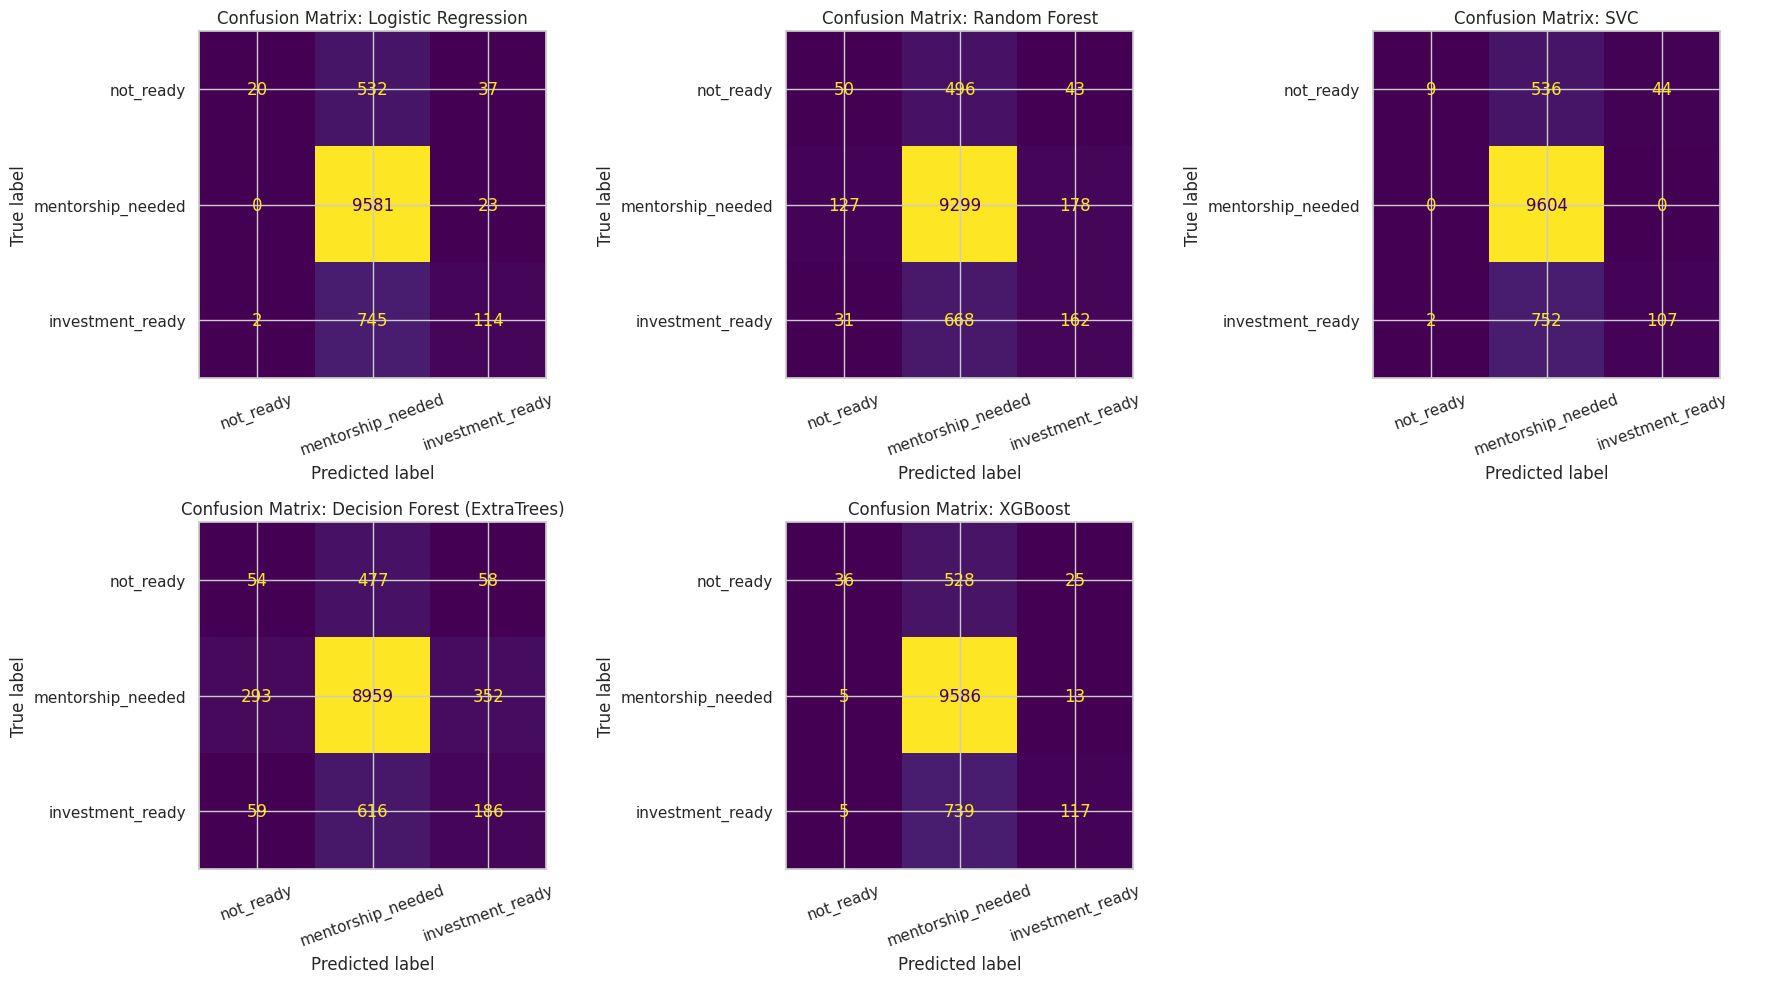

In [47]:
# Regenerate and display confusion matrices for classical models
n_models_classical = len(pred_cache)
n_cols_classical = 3
n_rows_classical = int(np.ceil(n_models_classical / n_cols_classical))
fig_classical, axes_classical = plt.subplots(n_rows_classical, n_cols_classical, figsize=(6 * n_cols_classical, 5 * n_rows_classical))
axes_classical = np.array(axes_classical).reshape(-1)

for idx, (name, (preds, _)) in enumerate(pred_cache.items()):
    cm = confusion_matrix(y_val, preds, labels=list(range(len(CLASS_NAMES))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(ax=axes_classical[idx], colorbar=False, xticks_rotation=20)
    axes_classical[idx].set_title(f'Confusion Matrix: {name}')

for j in range(idx + 1, len(axes_classical)):
    axes_classical[j].axis("off")

plt.tight_layout()
plt.show()

### Confusion Matrices for CNN Models

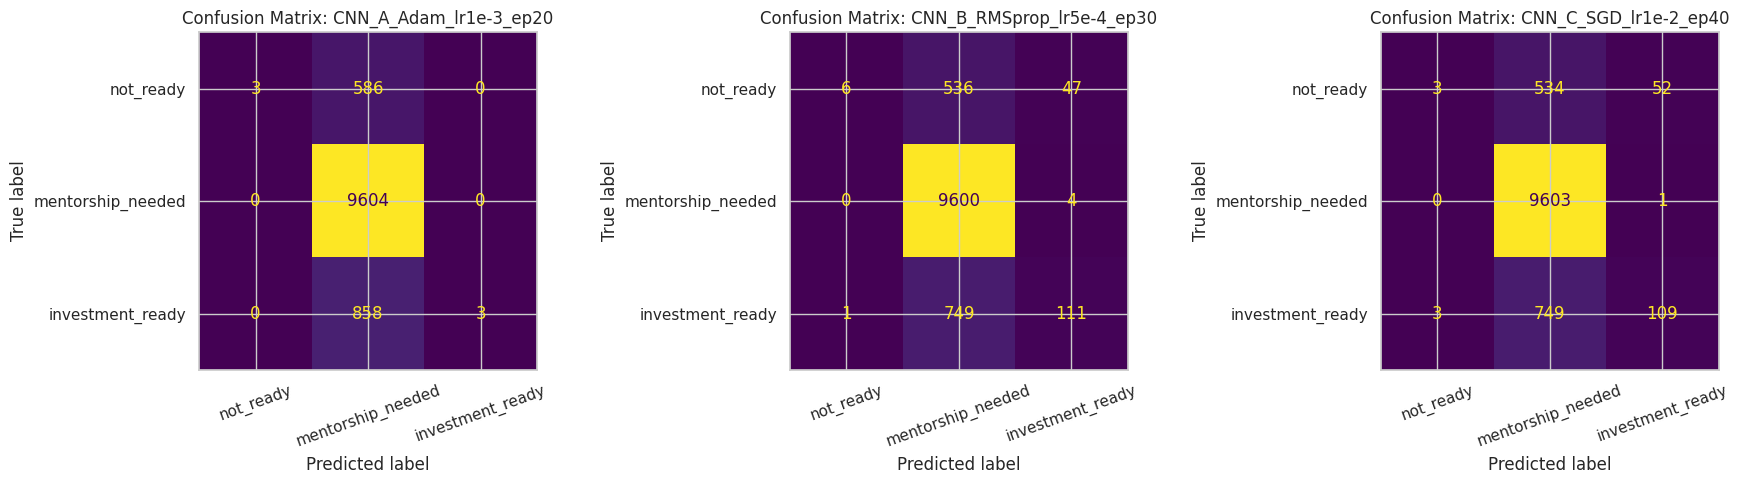

In [48]:
# Regenerate and display confusion matrices for CNN models
n_models_cnn = len(cnn_artifacts)
n_cols_cnn = 3
n_rows_cnn = int(np.ceil(n_models_cnn / n_cols_cnn))
fig_cnn, axes_cnn = plt.subplots(n_rows_cnn, n_cols_cnn, figsize=(6 * n_cols_cnn, 5 * n_rows_cnn))
axes_cnn = np.array(axes_cnn).reshape(-1)

for idx, (model_name, artifact) in enumerate(cnn_artifacts.items()):
    # Need to re-predict for CNN models to get y_pred_cnn
    preprocessor = artifact["preprocessor"]
    cnn_model = artifact["model"]

    X_val_proc_cnn = preprocessor.transform(X_val)
    if hasattr(X_val_proc_cnn, "toarray"):
        X_val_proc_cnn = X_val_proc_cnn.toarray()
    X_val_input_cnn = X_val_proc_cnn.reshape(X_val_proc_cnn.shape[0], X_val_proc_cnn.shape[1], 1).astype(np.float32)
    y_pred_cnn = np.argmax(cnn_model.predict(X_val_input_cnn, verbose=0), axis=1)

    cm_cnn = confusion_matrix(y_val, y_pred_cnn, labels=list(range(len(CLASS_NAMES))))
    disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=CLASS_NAMES)
    disp_cnn.plot(ax=axes_cnn[idx], colorbar=False, xticks_rotation=20)
    axes_cnn[idx].set_title(f'Confusion Matrix: {model_name}')

for j in range(idx + 1, len(axes_cnn)):
    axes_cnn[j].axis("off")

plt.tight_layout()
plt.show()